<a href="https://colab.research.google.com/github/claudio1975/Earthquakes_Risk_Modelling/blob/main/earthquake_prediction_initial_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://www.worldatlas.com/upload/97/eb/bf/earthquake-cause.png)

### Prepare Workspace

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px
import datetime
import scipy
import scipy.stats as stats
from scipy.stats import randint
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load Data Set

In [2]:
from google.colab import files 
uploaded = files.upload()

Saving train.csv to train.csv


In [3]:
df = pd.read_csv('train.csv',index_col=0,parse_dates=True)

### Have a look at the data set

In [4]:
print(df.shape)

(10188, 9)


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10188 entries, 1979-11-12 14:46:47.800000+00:00 to 2010-06-12 00:14:12.100000+00:00
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   latitude        10188 non-null  float64
 1   longitude       10188 non-null  float64
 2   depth           10188 non-null  float64
 3   mag             10188 non-null  float64
 4   magType         10188 non-null  object 
 5   place           10188 non-null  object 
 6   type            10188 non-null  object 
 7   locationSource  10188 non-null  object 
 8   magSource       10188 non-null  object 
dtypes: float64(4), object(5)
memory usage: 795.9+ KB
None


In [6]:
print(df.columns)

Index(['latitude', 'longitude', 'depth', 'mag', 'magType', 'place', 'type',
       'locationSource', 'magSource'],
      dtype='object')


In [7]:
df.head(10)

,latitude,longitude,depth,mag,magType,place,type,locationSource,magSource
time,,,,,,,,,
1979-11-12 14:46:47.800000+00:00,9.752,125.935,106.0,5.0,mb,"Mindanao, Philippines",earthquake,us,us
1979-11-18 15:59:20.500000+00:00,11.327,125.690,43.0,5.0,mb,"Samar, Philippines",earthquake,us,us
1979-11-19 22:17:20.200000+00:00,5.861,125.295,85.0,6.1,mb,"Mindanao, Philippines",earthquake,us,us
1979-11-21 22:59:05.300000+00:00,5.571,127.016,63.0,4.8,mb,Philippine Islands region,earthquake,us,us
1979-11-22 18:39:07.600000+00:00,16.339,121.586,33.0,4.8,mb,"Luzon, Philippines",earthquake,us,us
1979-11-23 20:45:05.400000+00:00,5.813,126.995,143.0,4.5,mb,"Mindanao, Philippines",earthquake,us,us
1979-11-24 18:45:28.600000+00:00,17.662,119.806,33.0,4.1,mb,Philippine Islands region,earthquake,us,us
1979-11-27 09:18:58.500000+00:00,7.178,126.304,33.0,4.6,mb,"Mindanao, Philippines",earthquake,us,us
1979-12-03 06:11:23.900000+00:00,8.652,126.460,85.0,4.8,mb,"Mindanao, Philippines",earthquake,us,us


In [8]:
# Check missing values 
missing = df.isnull().sum()/df.shape[0]*100
missing

latitude          0.0
longitude         0.0
depth             0.0
mag               0.0
magType           0.0
place             0.0
type              0.0
locationSource    0.0
magSource         0.0
dtype: float64

In [9]:
df.index.min()

Timestamp('1979-11-12 14:46:47.800000+0000', tz='UTC')

In [10]:
df.index.max()

Timestamp('2010-06-12 00:14:12.100000+0000', tz='UTC')

In [11]:
# formatting features
df.index = pd.to_datetime(df.index)

### Summary Statistics

In [12]:
# Summarize attribute distributions for data type of variables
obj_cols = [var for var in df.columns if df[var].dtype in ['object']]
df_cat = df[obj_cols].describe().T
df_cat

,count,unique,top,freq
magType,10188,5,mb,9116
place,10188,25,"Mindanao, Philippines",3951
type,10188,1,earthquake,10188
locationSource,10188,2,us,10187
magSource,10188,4,us,9277


In [13]:
# Summarize attribute distributions for data type of variables
num_cols = [var for var in df.columns if df[var].dtype in ['int64','float64']]
df_num = df[num_cols].describe().T
df_num

,count,mean,std,min,25%,50%,75%,max
latitude,10188.0,10.295055,3.775376,4.632,6.748,9.867,13.225,19.041
longitude,10188.0,124.567383,2.436067,117.115,122.584,125.605,126.438,129.797
depth,10188.0,70.589694,92.418147,1.100,33.000,34.450,74.800,678.000
mag,10188.0,4.630752,0.472133,3.000,4.300,4.600,4.900,7.700


In [14]:
# include date time variables for analysis
df['year'] = pd.DatetimeIndex(df.index).year 
df['month'] = pd.DatetimeIndex(df.index).month
df['day'] = pd.DatetimeIndex(df.index).day
df['hour'] = pd.DatetimeIndex(df.index).hour

### Functions

In [15]:
# Vis Chart
def plot_target(data, var):
    plt.rcParams['figure.figsize']=(20,15)
    plt.suptitle('Earthquake Magnitude Exploratory Data Analysis',fontsize=25)
    plt.subplot(2,2,1)
    x=data[var]
    plt.hist(x,color='green',edgecolor='black')
    plt.title('{} histogram'.format(var))
    plt.ylabel('{}'.format(var),fontsize=15)
    plt.yticks(rotation=45, fontsize=15)
    plt.xticks(rotation=45, fontsize=15)
    
    
    plt.subplot(2,2,2)
    x=data[var]
    sns.boxplot(x, color="orange")
    plt.title('{} boxplot'.format(var))
    plt.xlabel('{}'.format(var),fontsize=15)
    plt.yticks(rotation=45, fontsize=15)
    plt.xticks(rotation=45, fontsize=15)
    
    
    plt.subplot(2,2,3)
    res = stats.probplot(data[var], plot=plt)
    plt.title('{} Q-Q plot'.format(var))
    plt.yticks(rotation=45, fontsize=15)
    plt.xticks(rotation=45, fontsize=15)
    
    plt.subplot(2,2,4)
    # autocorrelation plot 
    autocorrelation_plot(df[var])
    plt.title("{} vs time autocorrelation".format(var)) 
    plt.yticks(rotation=45, fontsize=15)
    plt.xticks(rotation=45, fontsize=15)
    
    plt.show()

In [16]:
# Vis Chart
def barplot(data, var):
    plt.rcParams['figure.figsize']=(15,10)
    df= data.groupby(data[var])['mag'].count()
    df.plot.bar(color='blue')
    plt.suptitle('Distribution Magnitude observations per {}'.format(var),fontsize=25)
    plt.xlabel('{}'.format(var), fontsize=20)
    plt.ylabel('count mag', fontsize=20)
    plt.yticks(rotation=0, fontsize=20)
    plt.xticks(rotation=45, fontsize=20)
    plt.show()

In [17]:
# Vis Chart
def barplot2(data, var):
    plt.rcParams['figure.figsize']=(20,10)
    df= data.groupby(data[var])['mag'].count().sort_values(ascending = True)
    df.plot.barh(color='blue')
    plt.suptitle('Distribution Magnitude observations per {}'.format(var),fontsize=25)
    plt.xlabel('count mag', fontsize=25)
    plt.ylabel('{}'.format(var), fontsize=25)
    plt.yticks(rotation=0, fontsize=25)
    plt.xticks(rotation=45, fontsize=25)
    plt.show()

In [18]:
# Vis Chart
def plot_cat(data, col1, col2):
    plt.rcParams['figure.figsize']=(20,30)
    plt.subplot(2,1,1)
    data.groupby(col1).count()[col2].plot(kind='pie',autopct='%.0f%%', labels=None).set_title("Pie {} Variable Distribution".format(col1))
    plt.subplot(2,1,2)
    sns.countplot(x=data[col1], data=data).set_title("Barplot {} Variable Distribution".format(col1))
    plt.yticks(rotation=0, fontsize=15)
    plt.xticks(rotation=90, fontsize=15)
    plt.show()

In [19]:
# Vis Chart
def plot_num(data, var):
    plt.rcParams['figure.figsize']=(15,5)
    plt.subplot(1,3,1)
    x=data[var]
    plt.hist(x,color='green',edgecolor='black')
    plt.title('{} histogram'.format(var))
    plt.yticks(rotation=0, fontsize=15)
    plt.xticks(rotation=45, fontsize=15)
    
    
    plt.subplot(1,3,2)
    x=data[var]
    sns.boxplot(x, color="orange")
    plt.title('{} boxplot'.format(var))
    plt.yticks(rotation=0, fontsize=15)
    plt.xticks(rotation=45, fontsize=15)
    
    
    plt.subplot(1,3,3)
    res = stats.probplot(data[var], plot=plt)
    plt.title('{} Q-Q plot'.format(var))
    plt.yticks(rotation=0, fontsize=15)
    plt.xticks(rotation=45, fontsize=15)
    
    
    plt.show()

In [20]:
fig=px.density_mapbox(df, lat='latitude',lon='longitude',radius=1,
                    zoom=3.5, mapbox_style='stamen-terrain',center=dict(lat=11,lon=125),
                      title='Earthquake Magnitude Geographical Distribution')
fig.show()

### Data Distribution

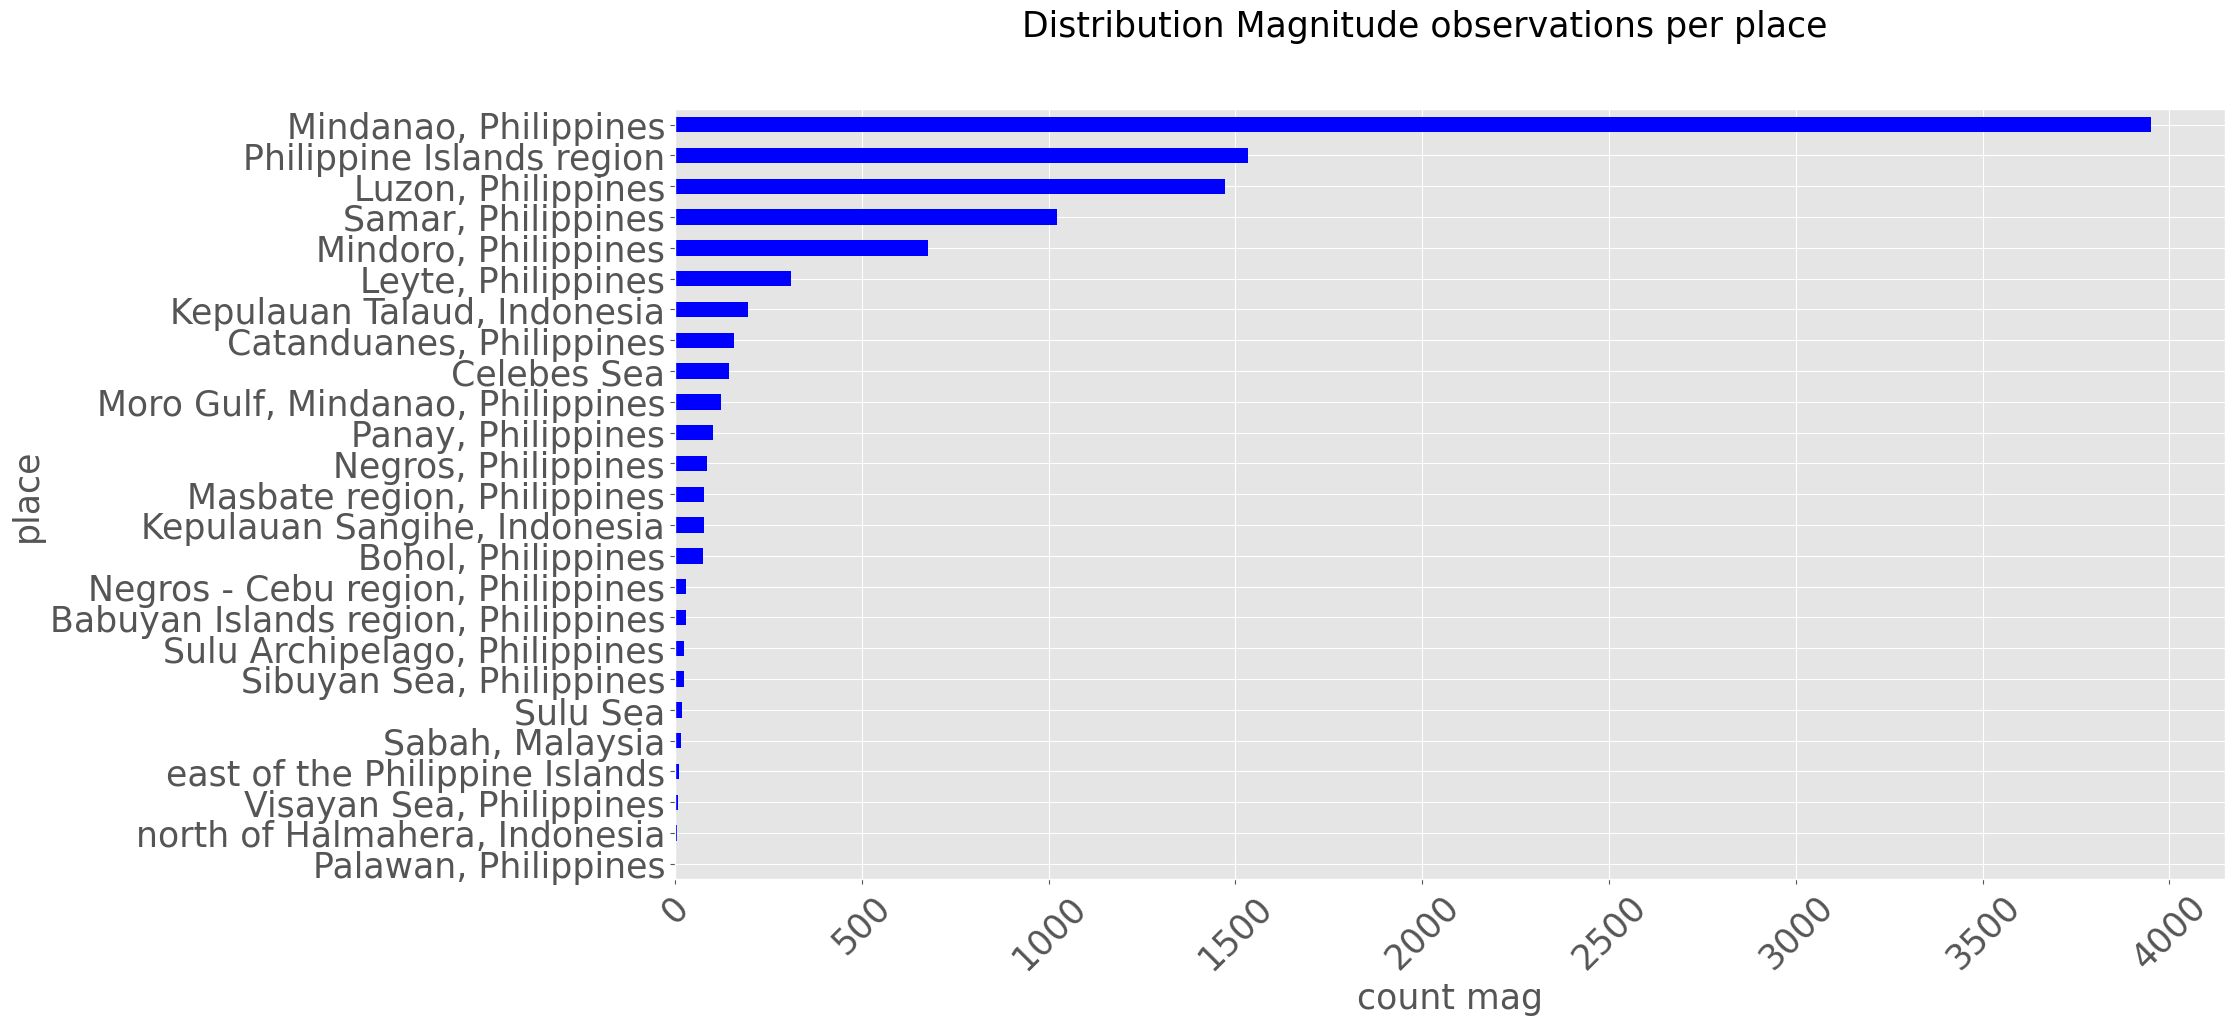

In [21]:
barplot2(df, 'place')

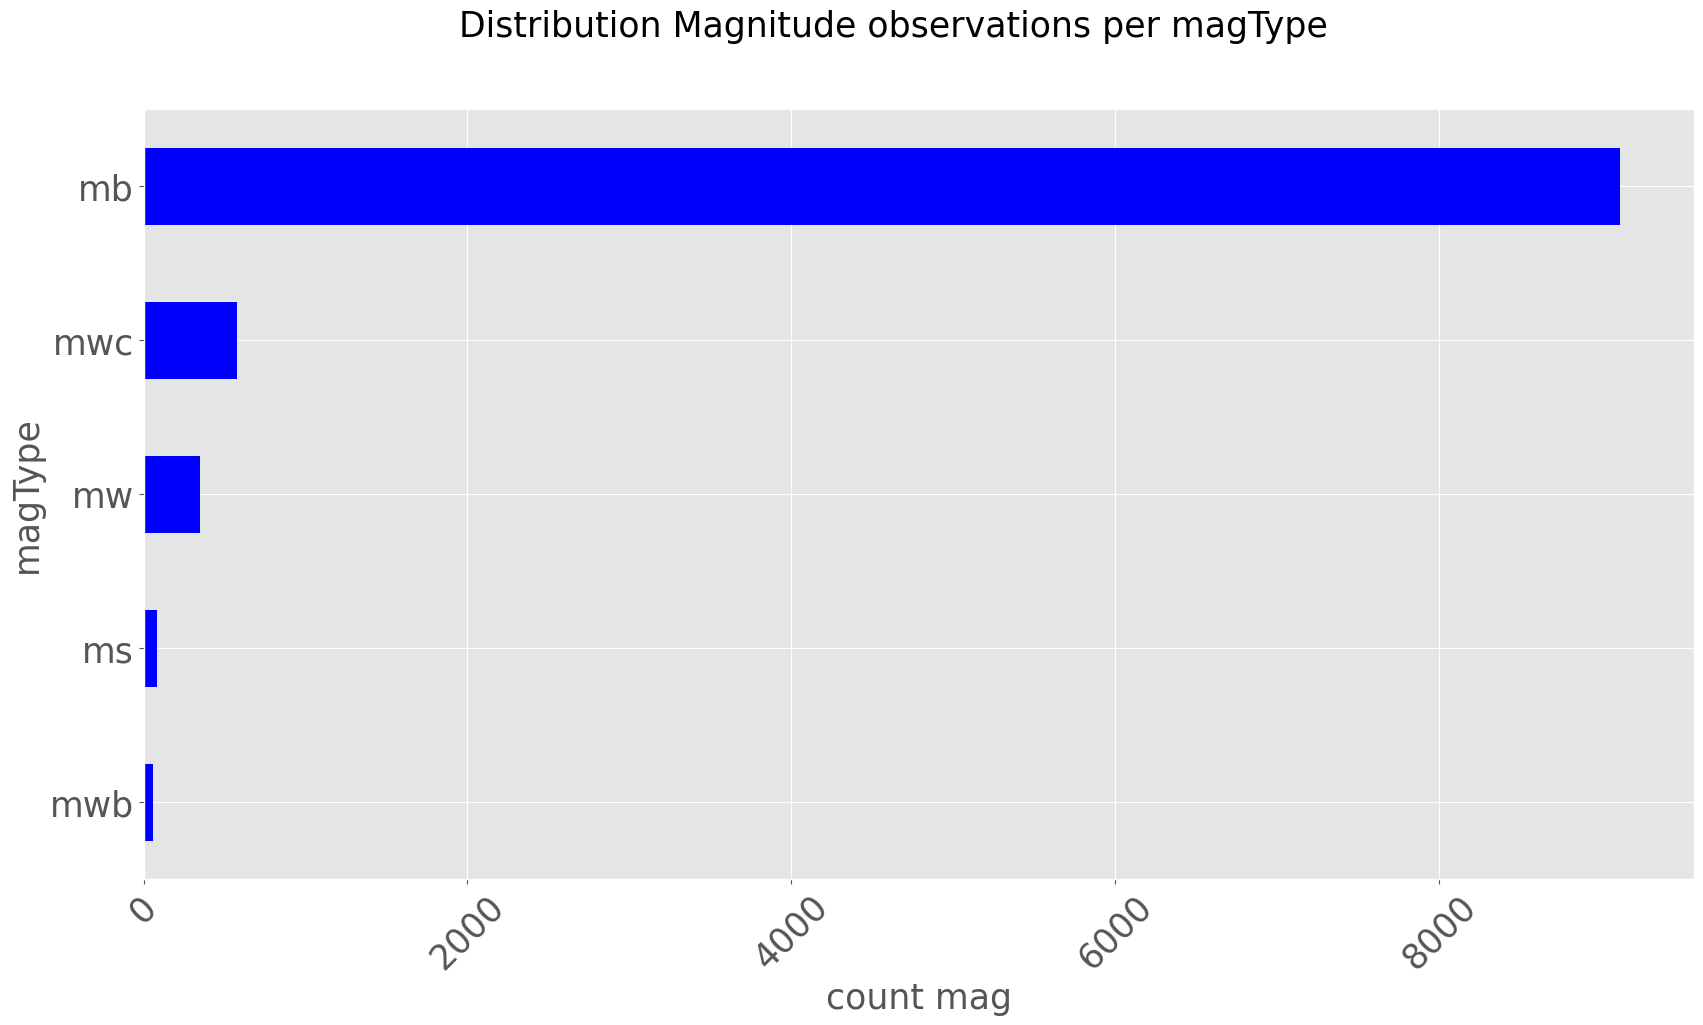

In [22]:
barplot2(df, 'magType')

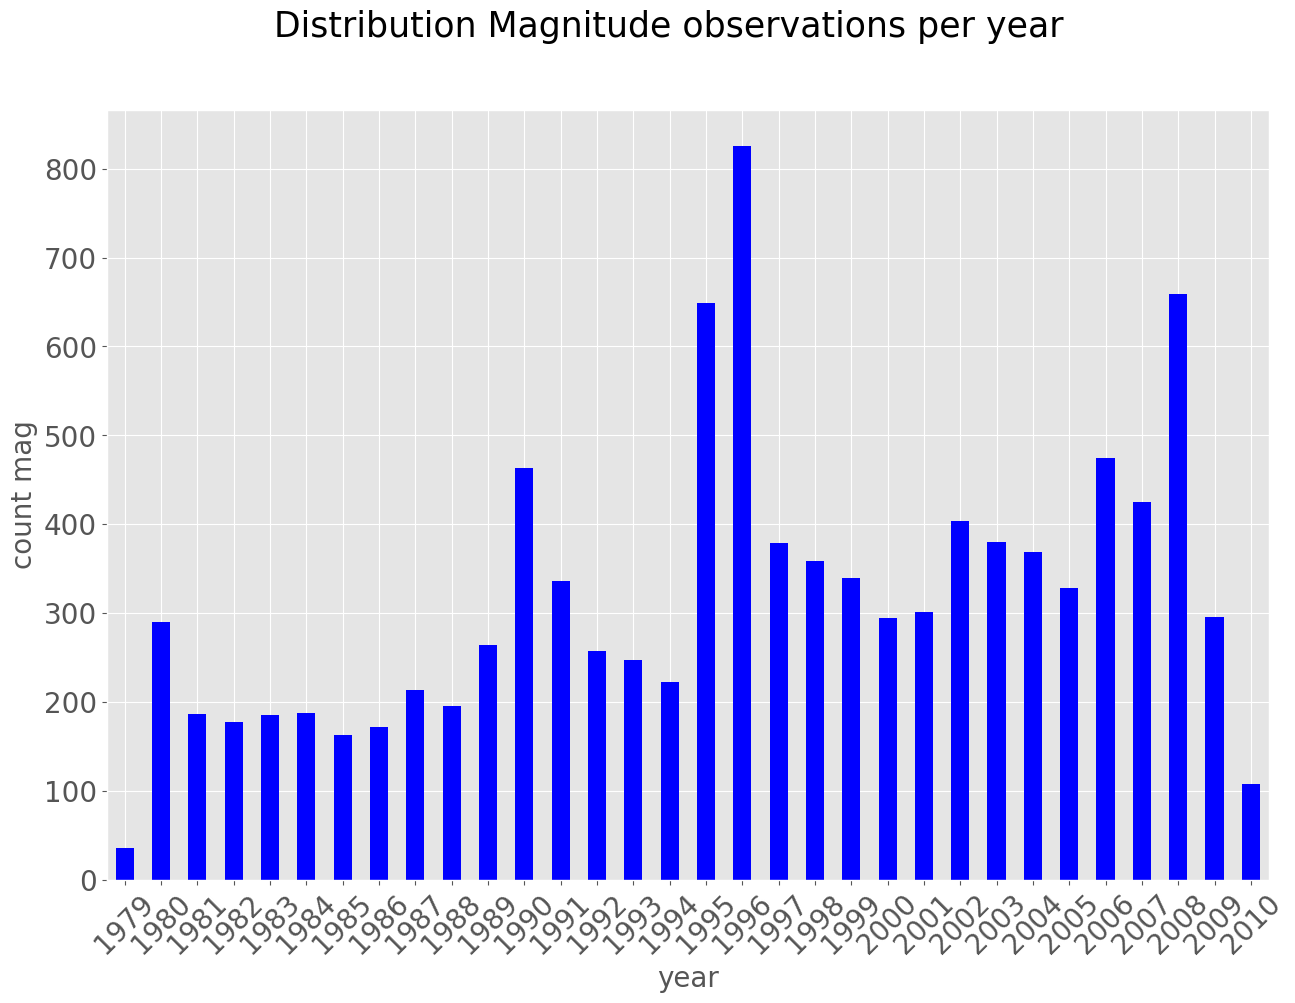

In [23]:
# Count distribution
barplot(df,'year')

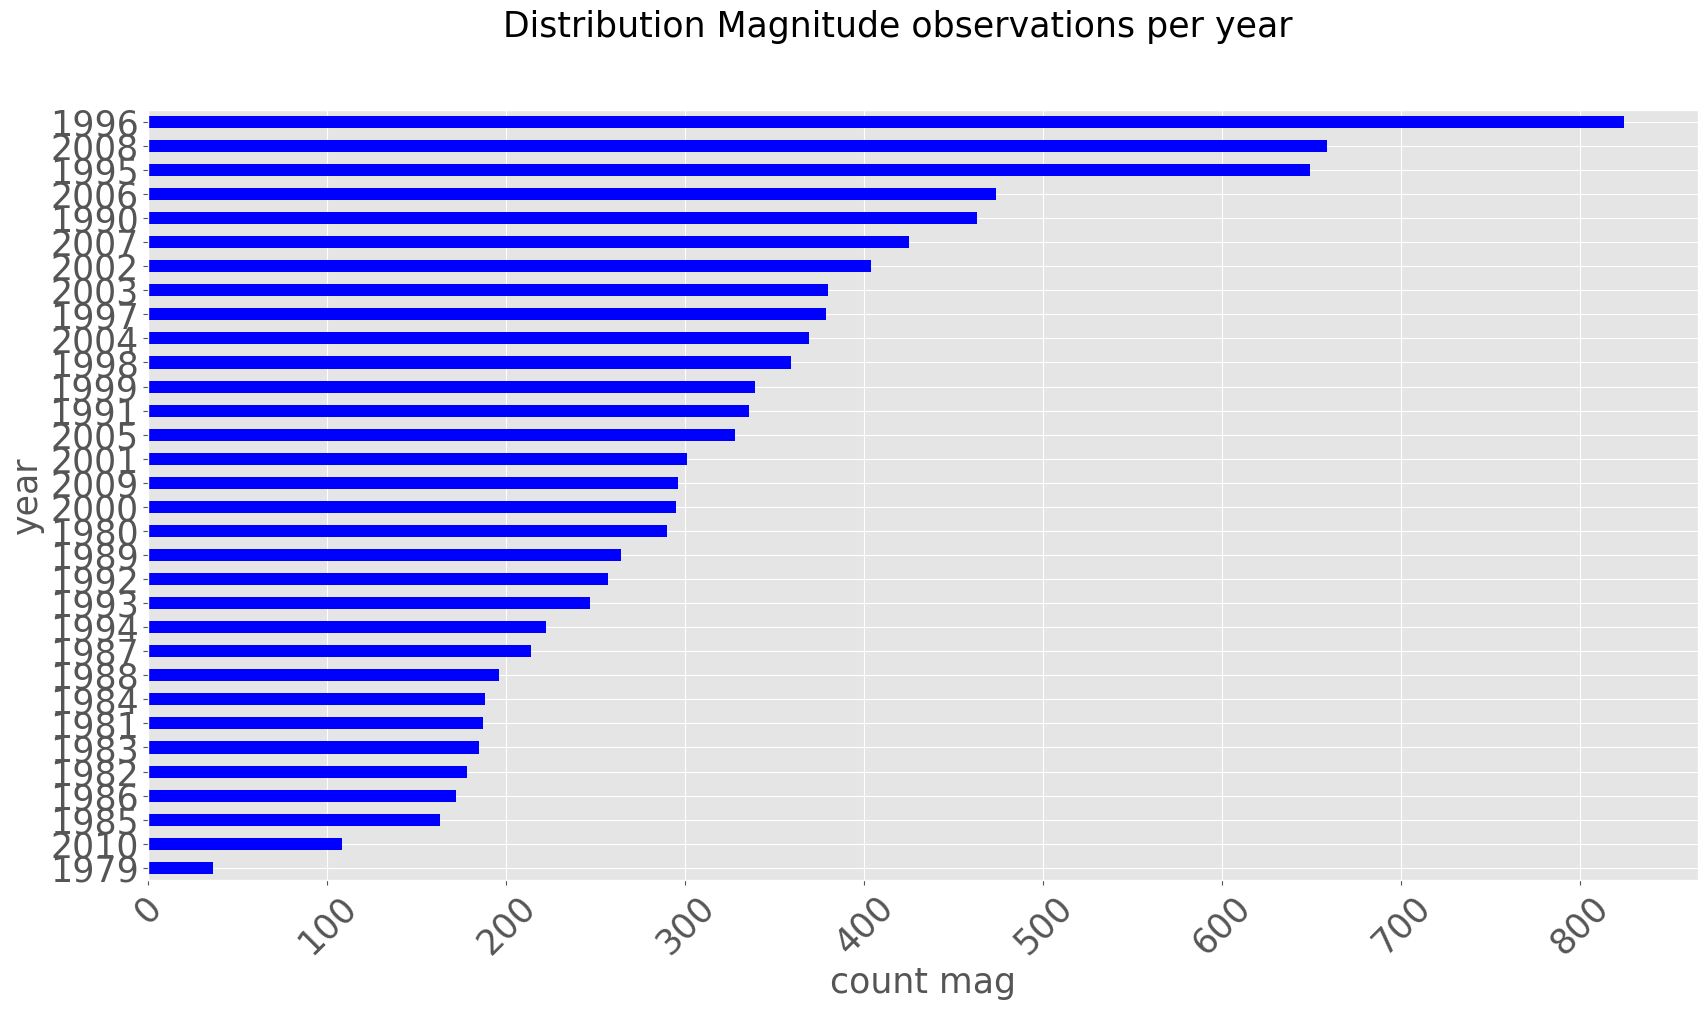

In [24]:
# count distribution in order of occurence
barplot2(df, 'year')

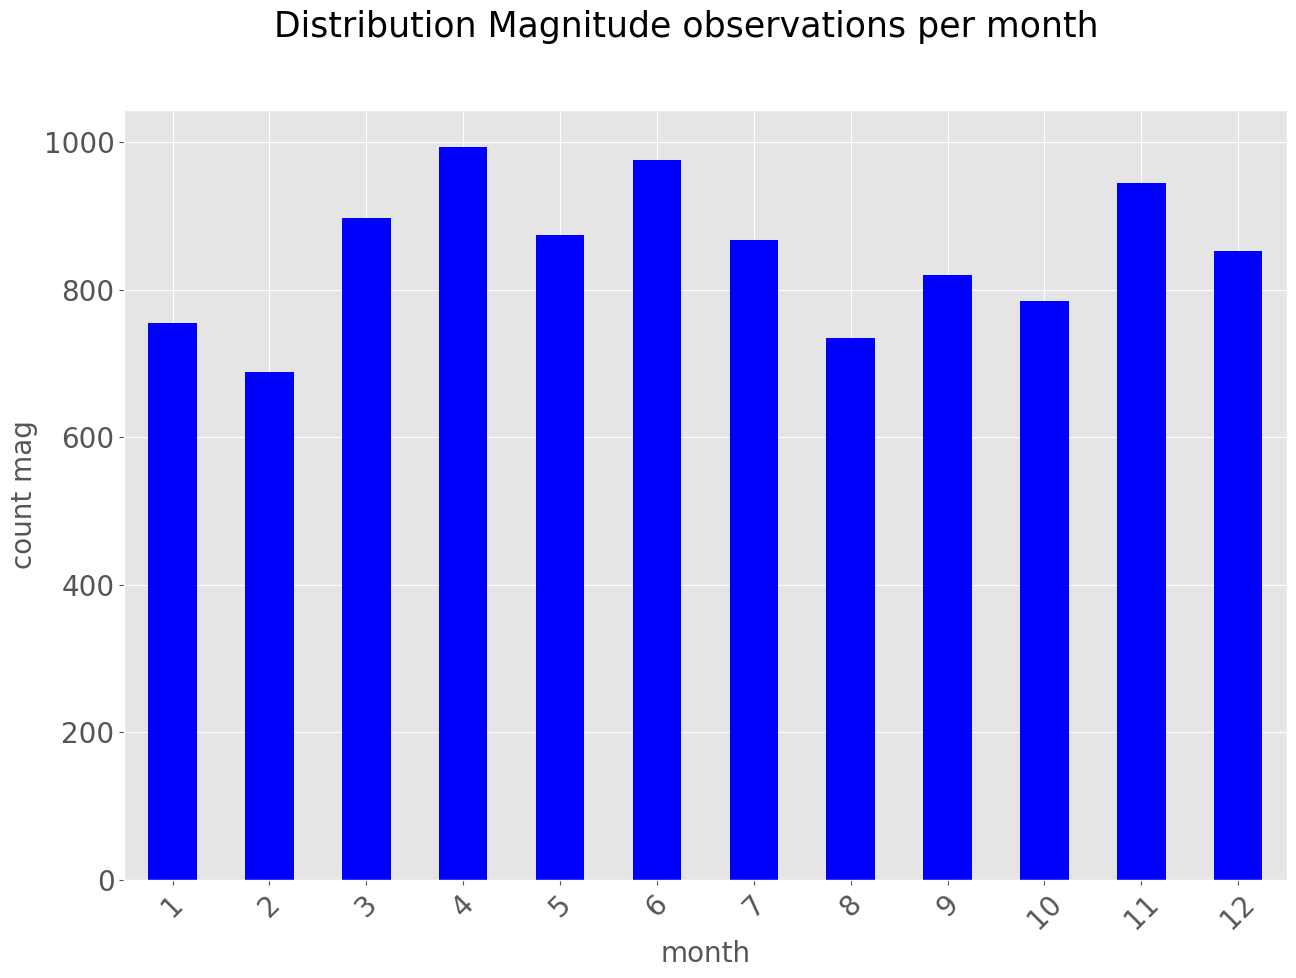

In [25]:
# Count distribution
barplot(df,'month')

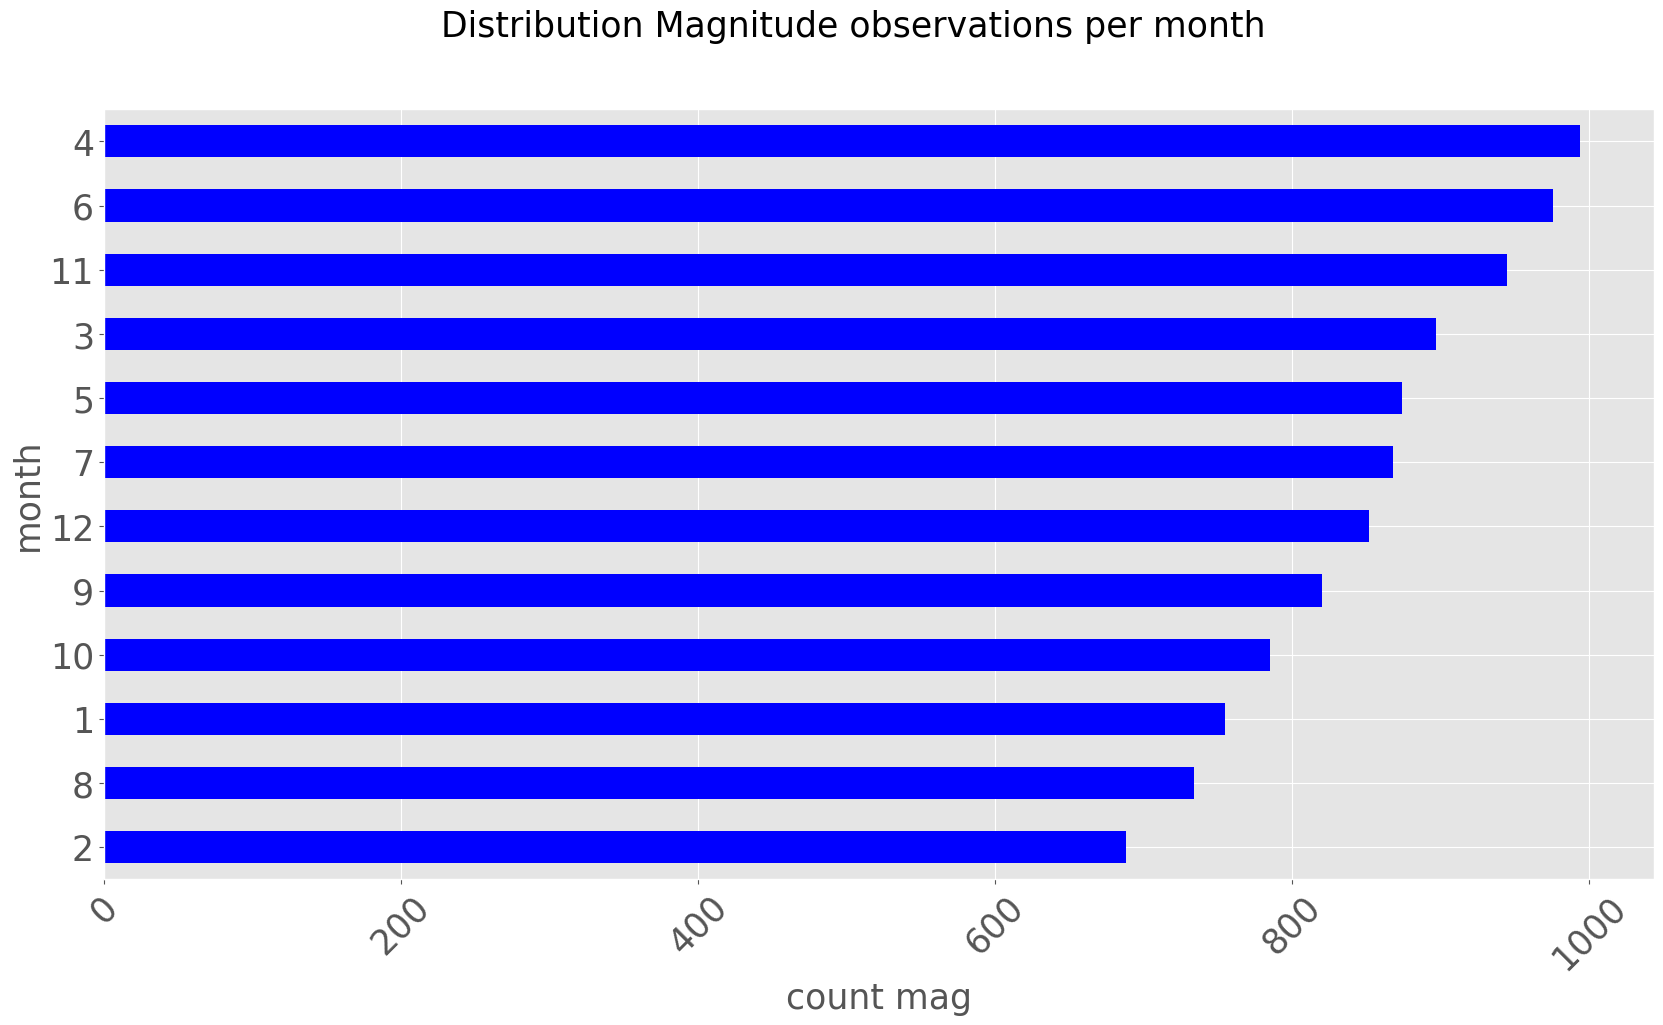

In [26]:
# count distribution in order of occurence
barplot2(df, 'month')

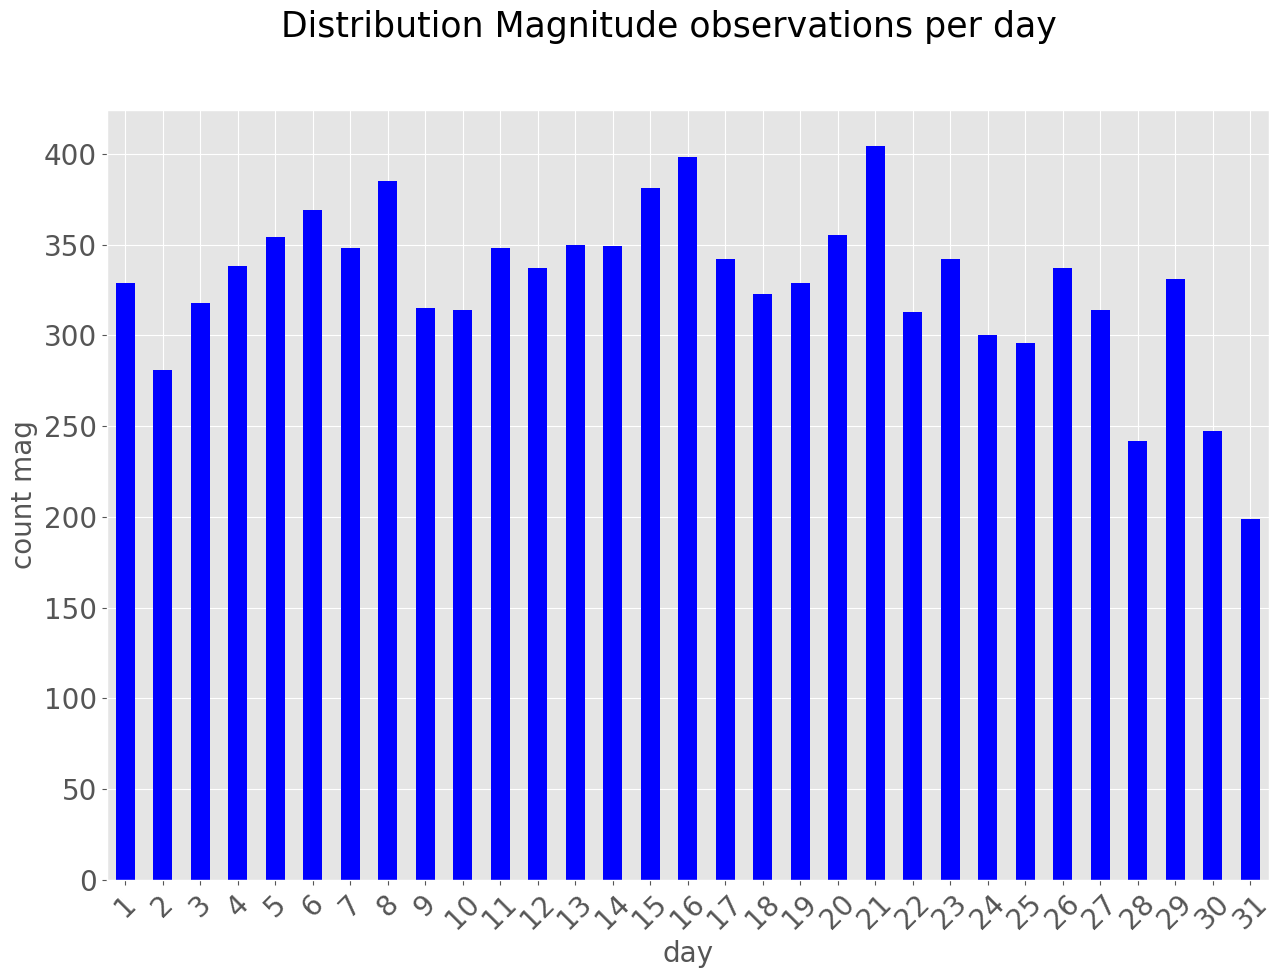

In [27]:
# Count distribution
barplot(df,'day')

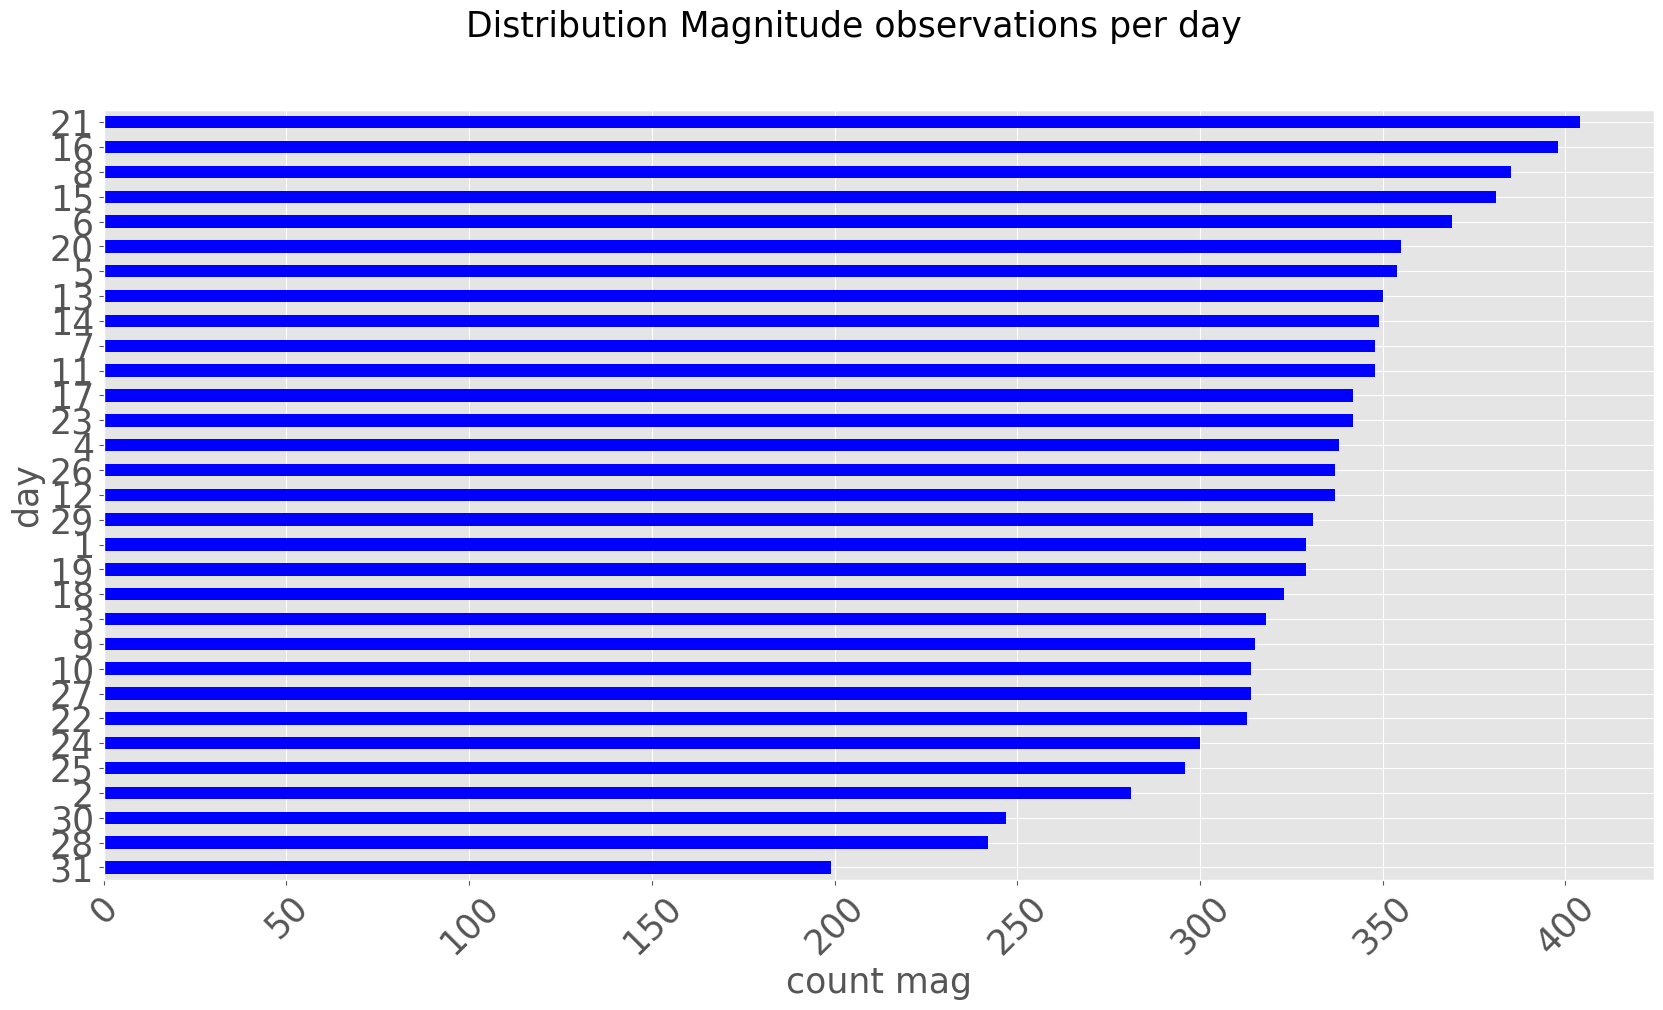

In [28]:
# count distribution in order of occurence
barplot2(df, 'day')

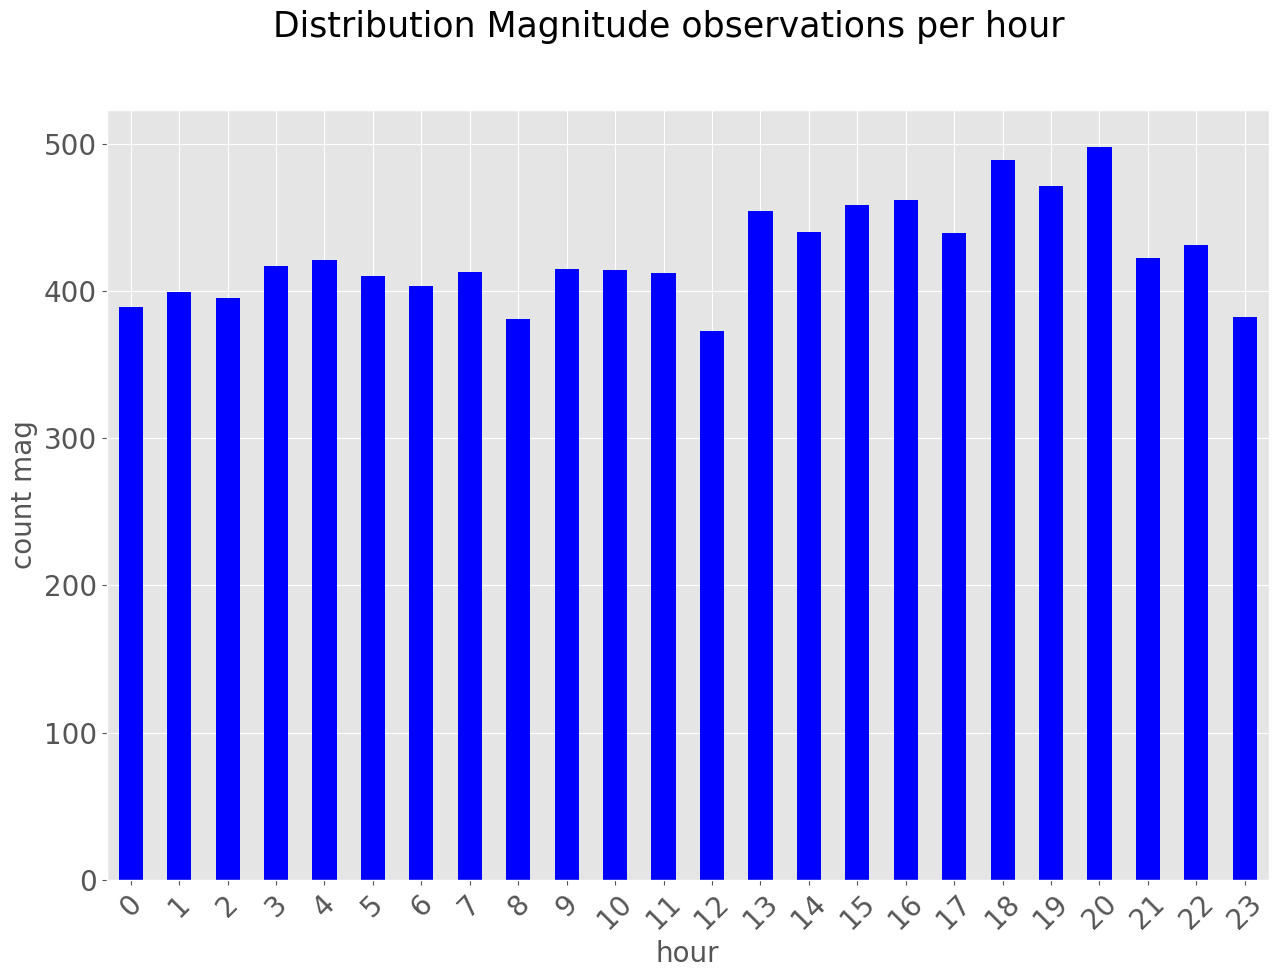

In [29]:
# Count distribution
barplot(df,'hour')

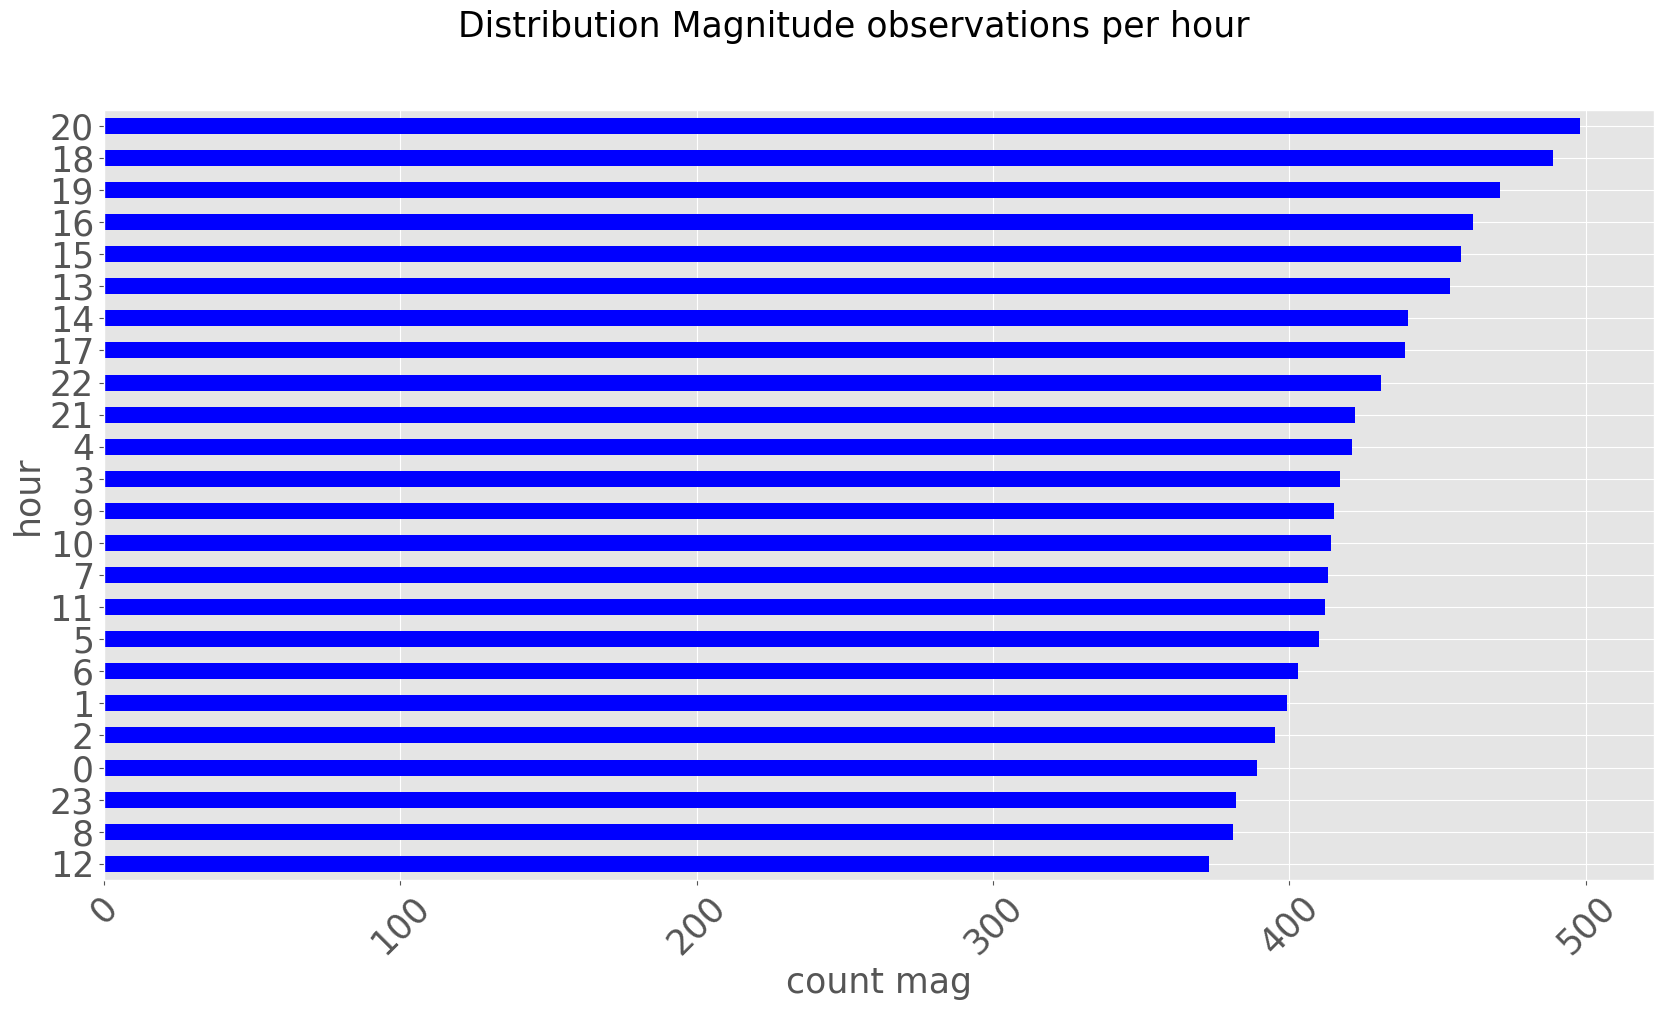

In [30]:
# count distribution in order of occurence
barplot2(df, 'hour')

### Target Variable Analysis

In [31]:
# Univariate analysis looking at Mean, Standard Deviation, Skewness and Kurtosis
print('\nMean :', np.mean(df['mag']),  
        '\nVariance :', np.var(df['mag']),
        '\nStandard Deviation :', np.var(df['mag']**0.5), 
        '\nSkewness :', stats.skew(df['mag']), 
        '\nKurtosis :', stats.kurtosis(df['mag']))


Mean : 4.630751864939144 
Variance : 0.2228872635173308 
Standard Deviation : 0.011575609886290344 
Skewness : 1.064887195998622 
Kurtosis : 3.2781340208869736


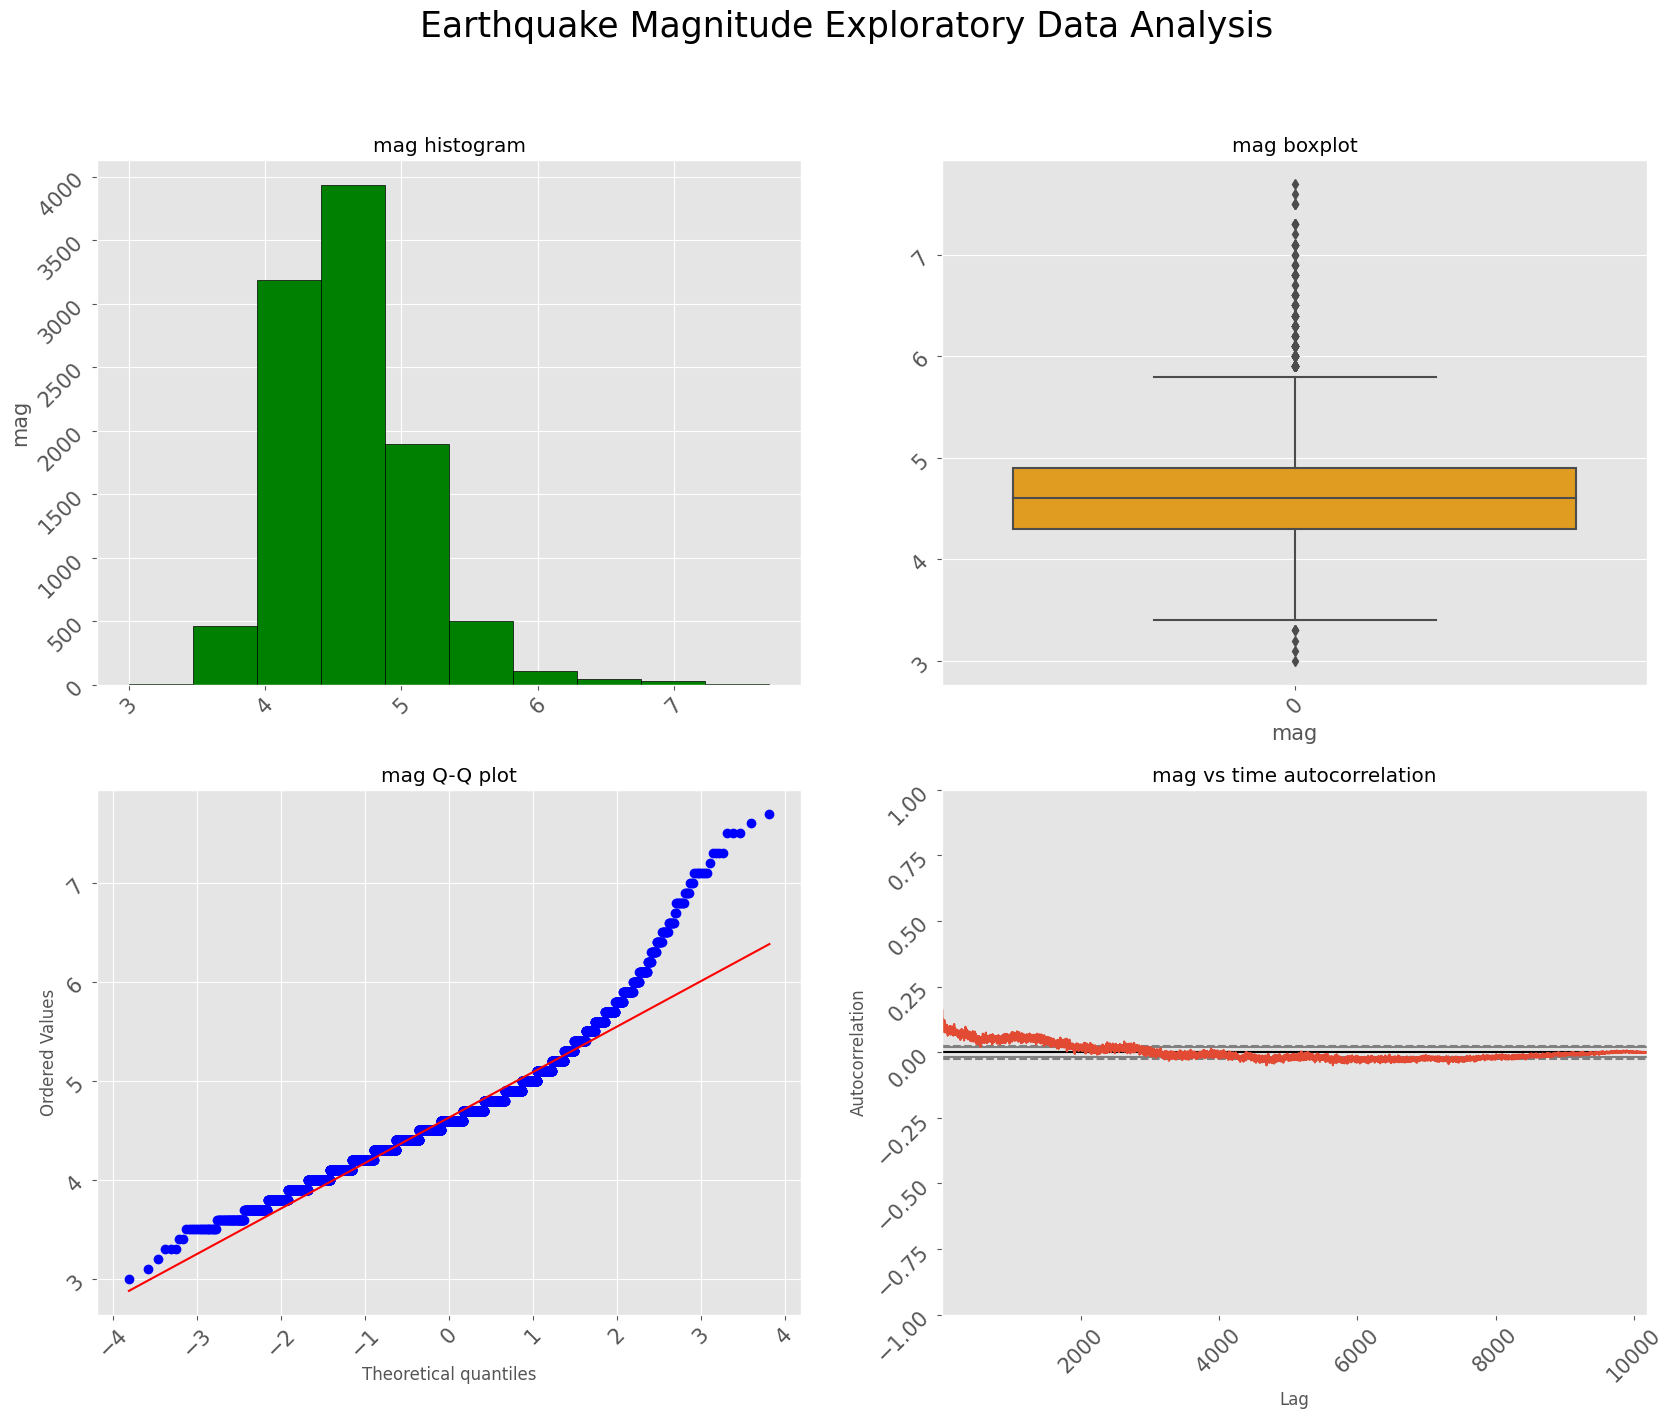

In [32]:
plot_target(df, var='mag')

In [33]:
# Split data set between target variable and features
X_full = df.copy()
y = X_full.mag
X_full.drop(['mag'], axis=1, inplace=True)
# Drop useless features
X_full.drop(['year','month','day','hour'], axis=1, inplace=True)

### Categorical features analysis

In [34]:
# let's have a look at how many labels for categorical features
for col in X_full.columns:
    if X_full[col].dtype =="object":
        print(col, ': ', len(X_full[col].unique()), ' labels')

magType :  5  labels
place :  25  labels
type :  1  labels
locationSource :  2  labels
magSource :  4  labels


In [35]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [var for var in X_full.columns if
                    X_full[var].dtype == "object"]

In [36]:
# Subset with categorical features
cat = X_full[categorical_cols]
cat.columns

Index(['magType', 'place', 'type', 'locationSource', 'magSource'], dtype='object')

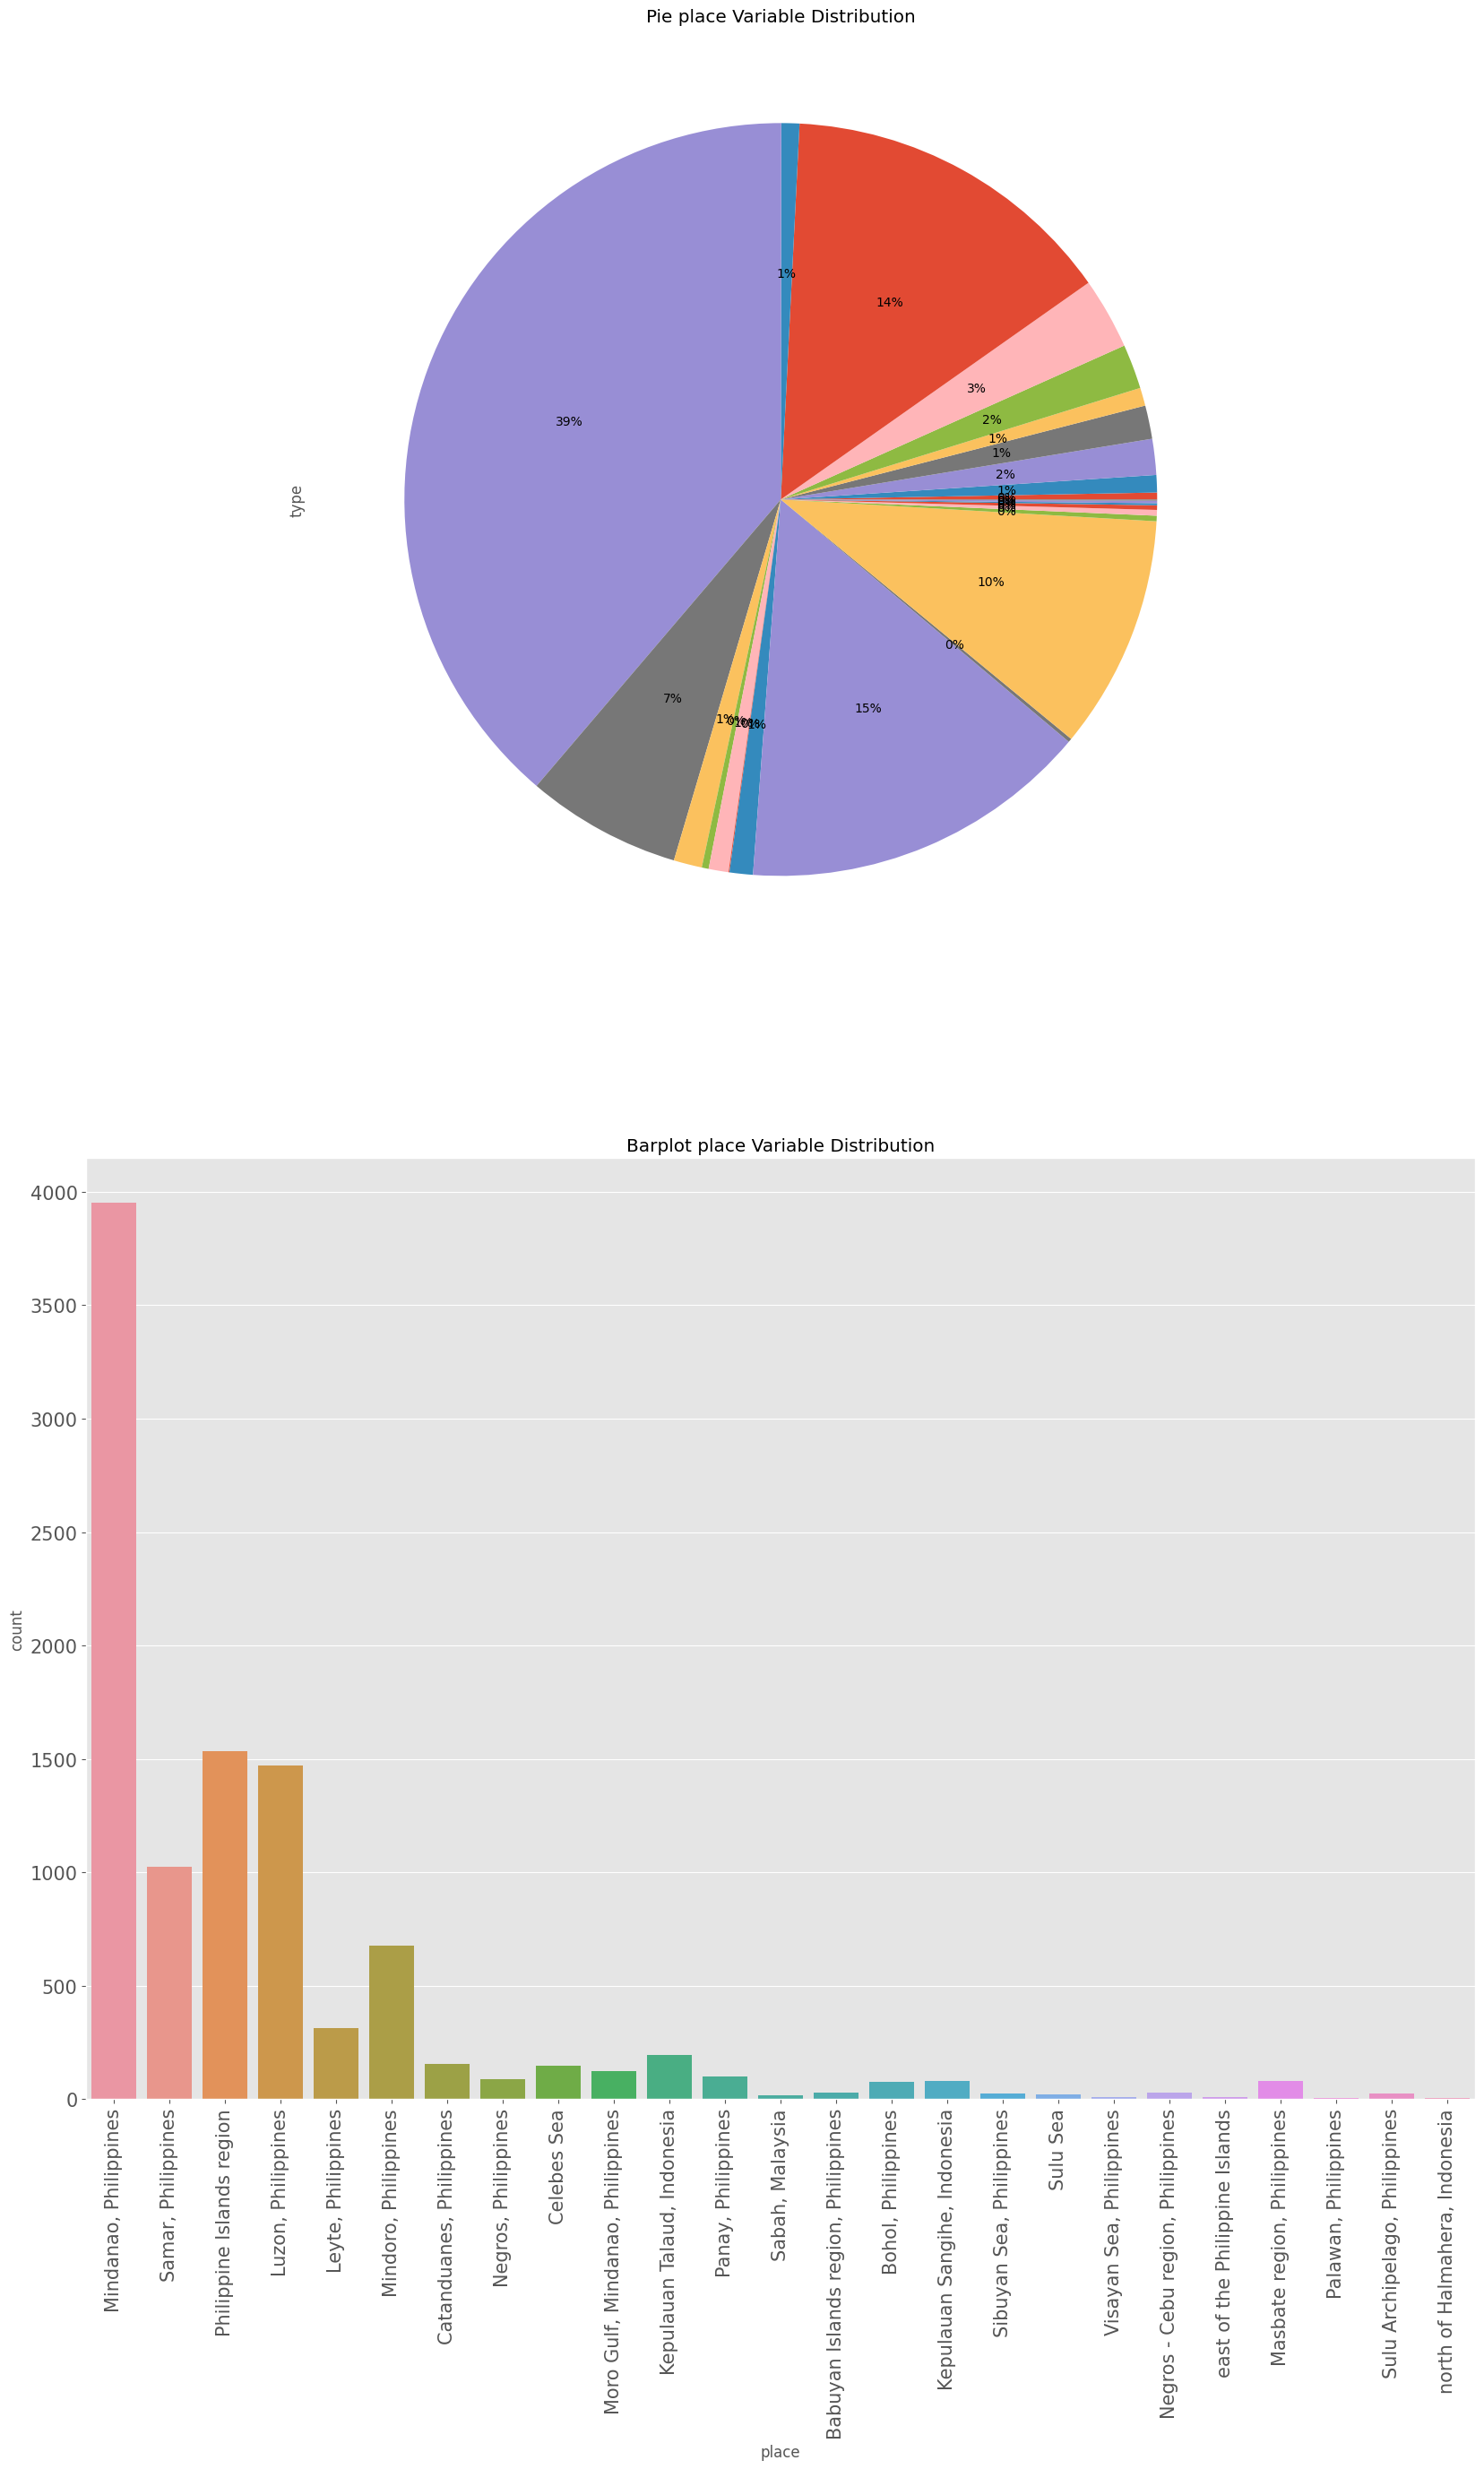

In [37]:
plot_cat(df, col1='place', col2='type')

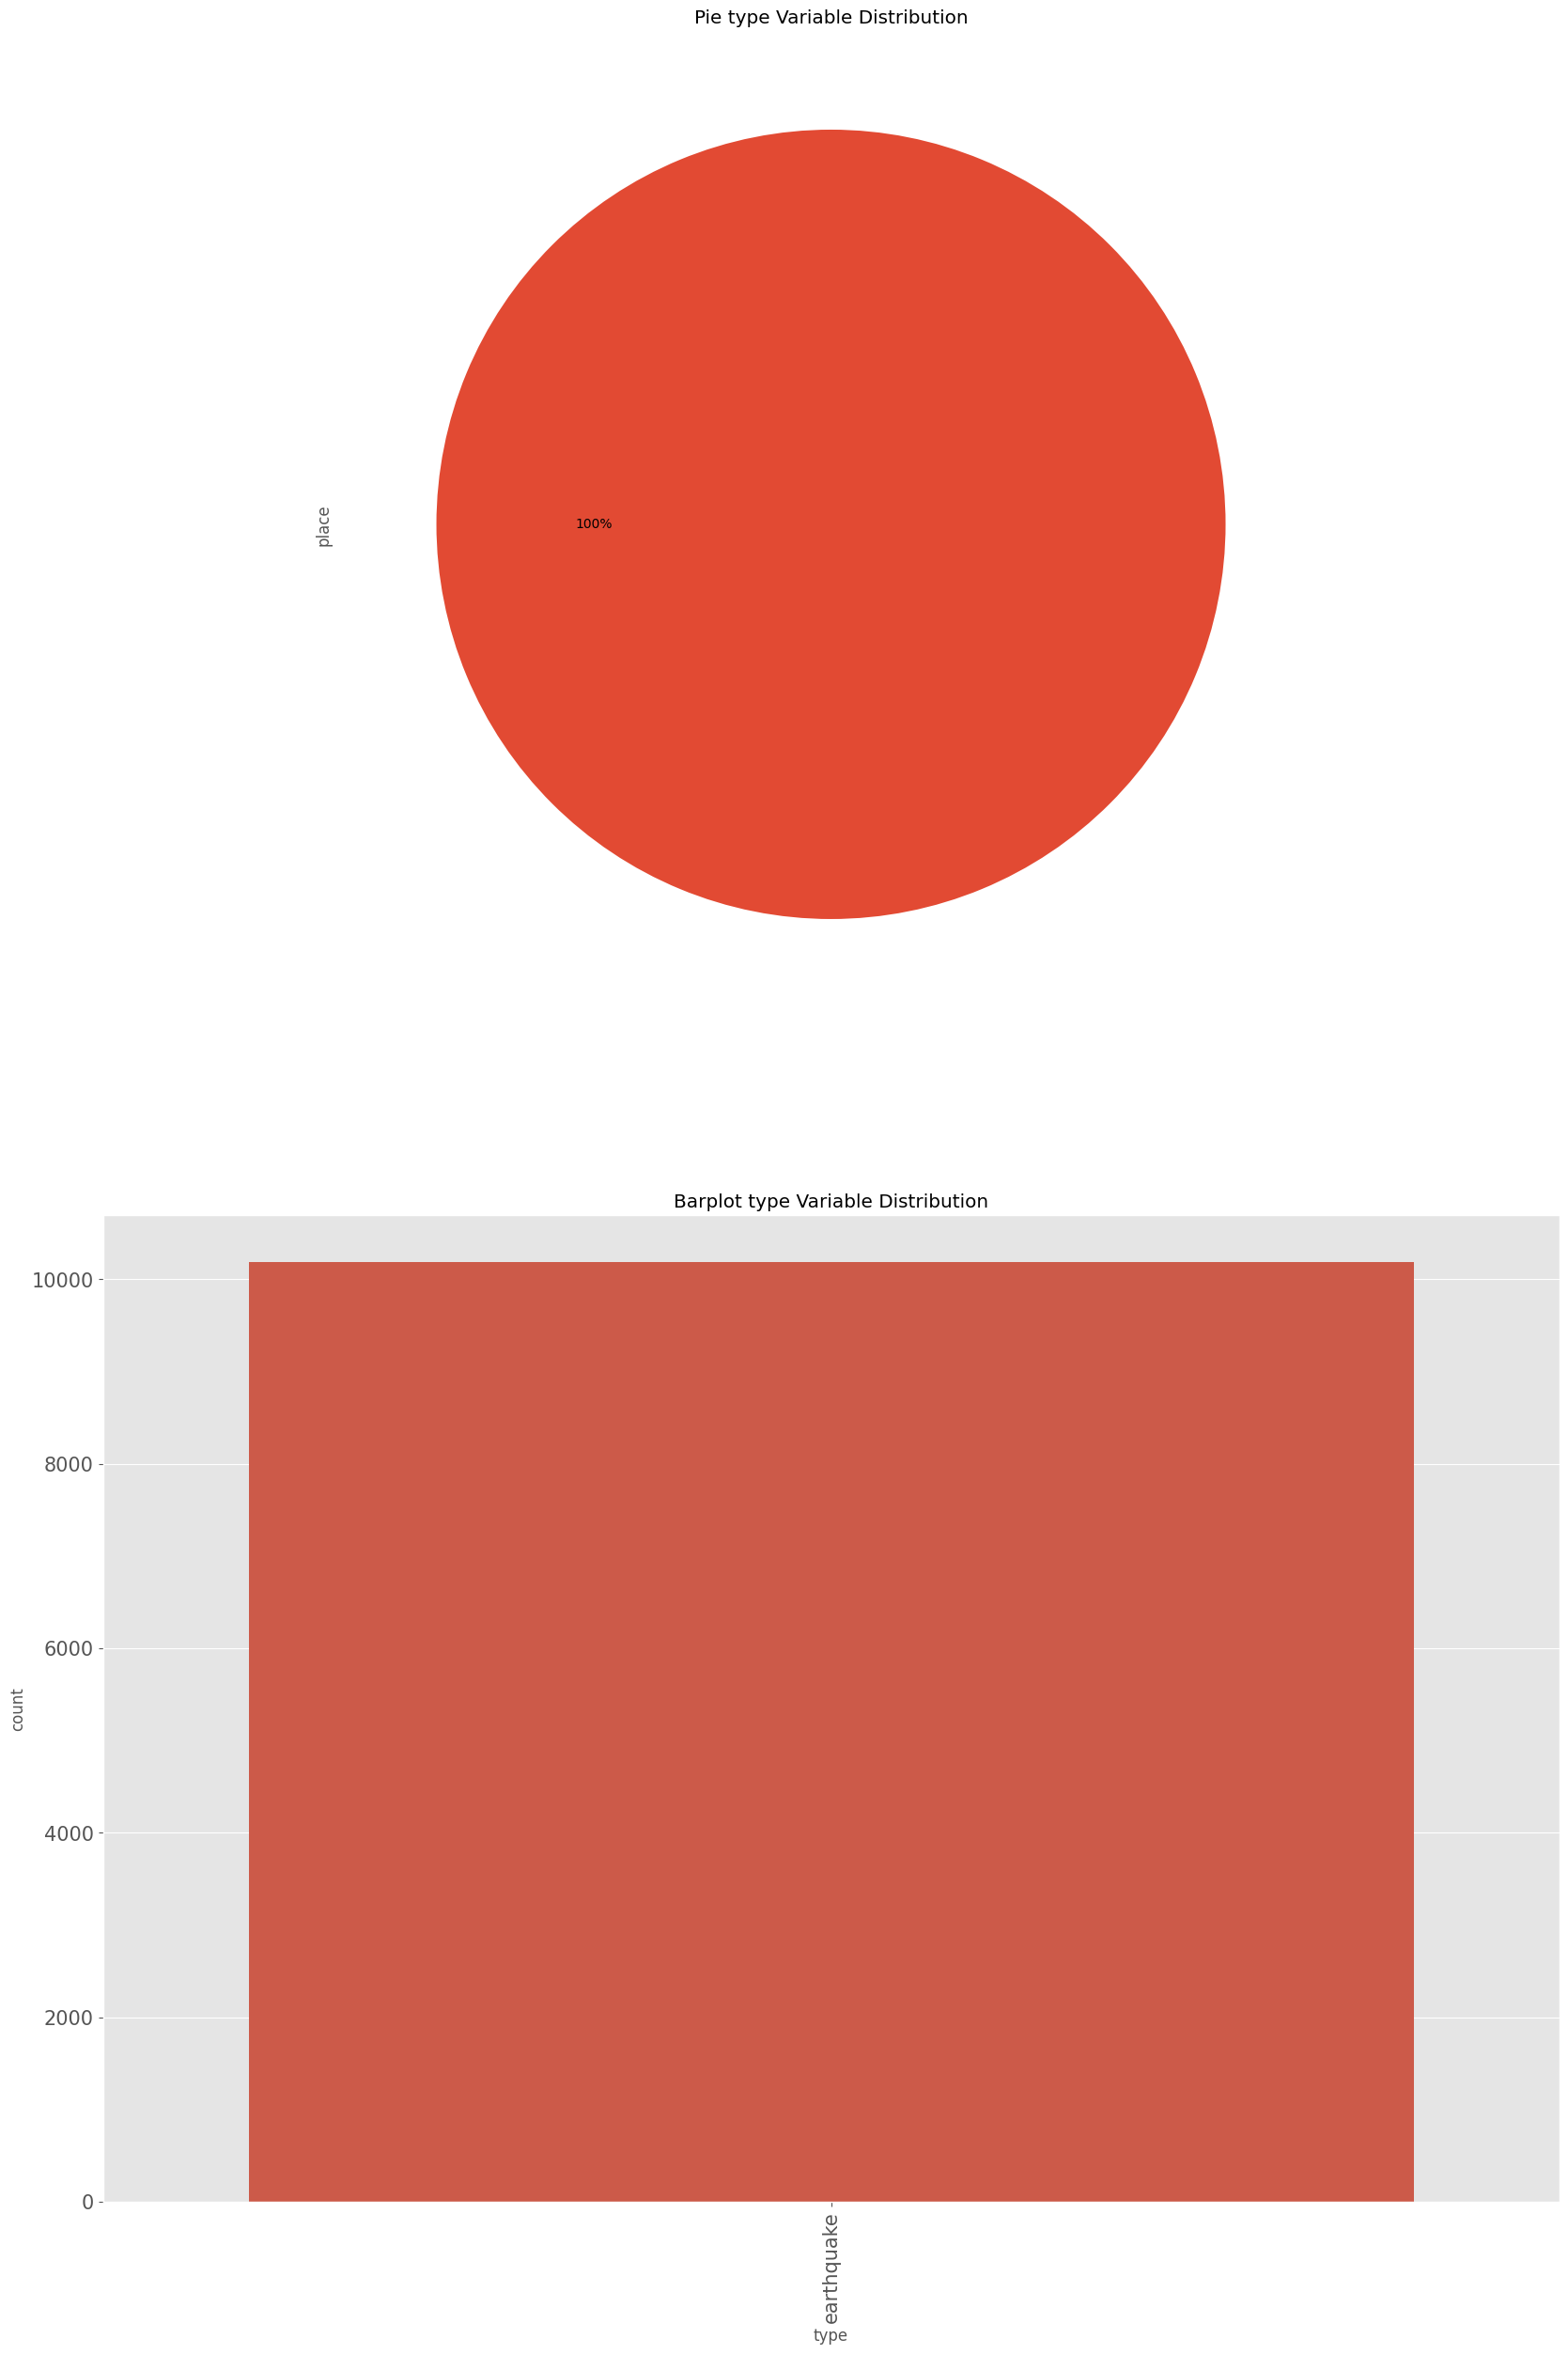

In [38]:
plot_cat(df, col1='type', col2='place')

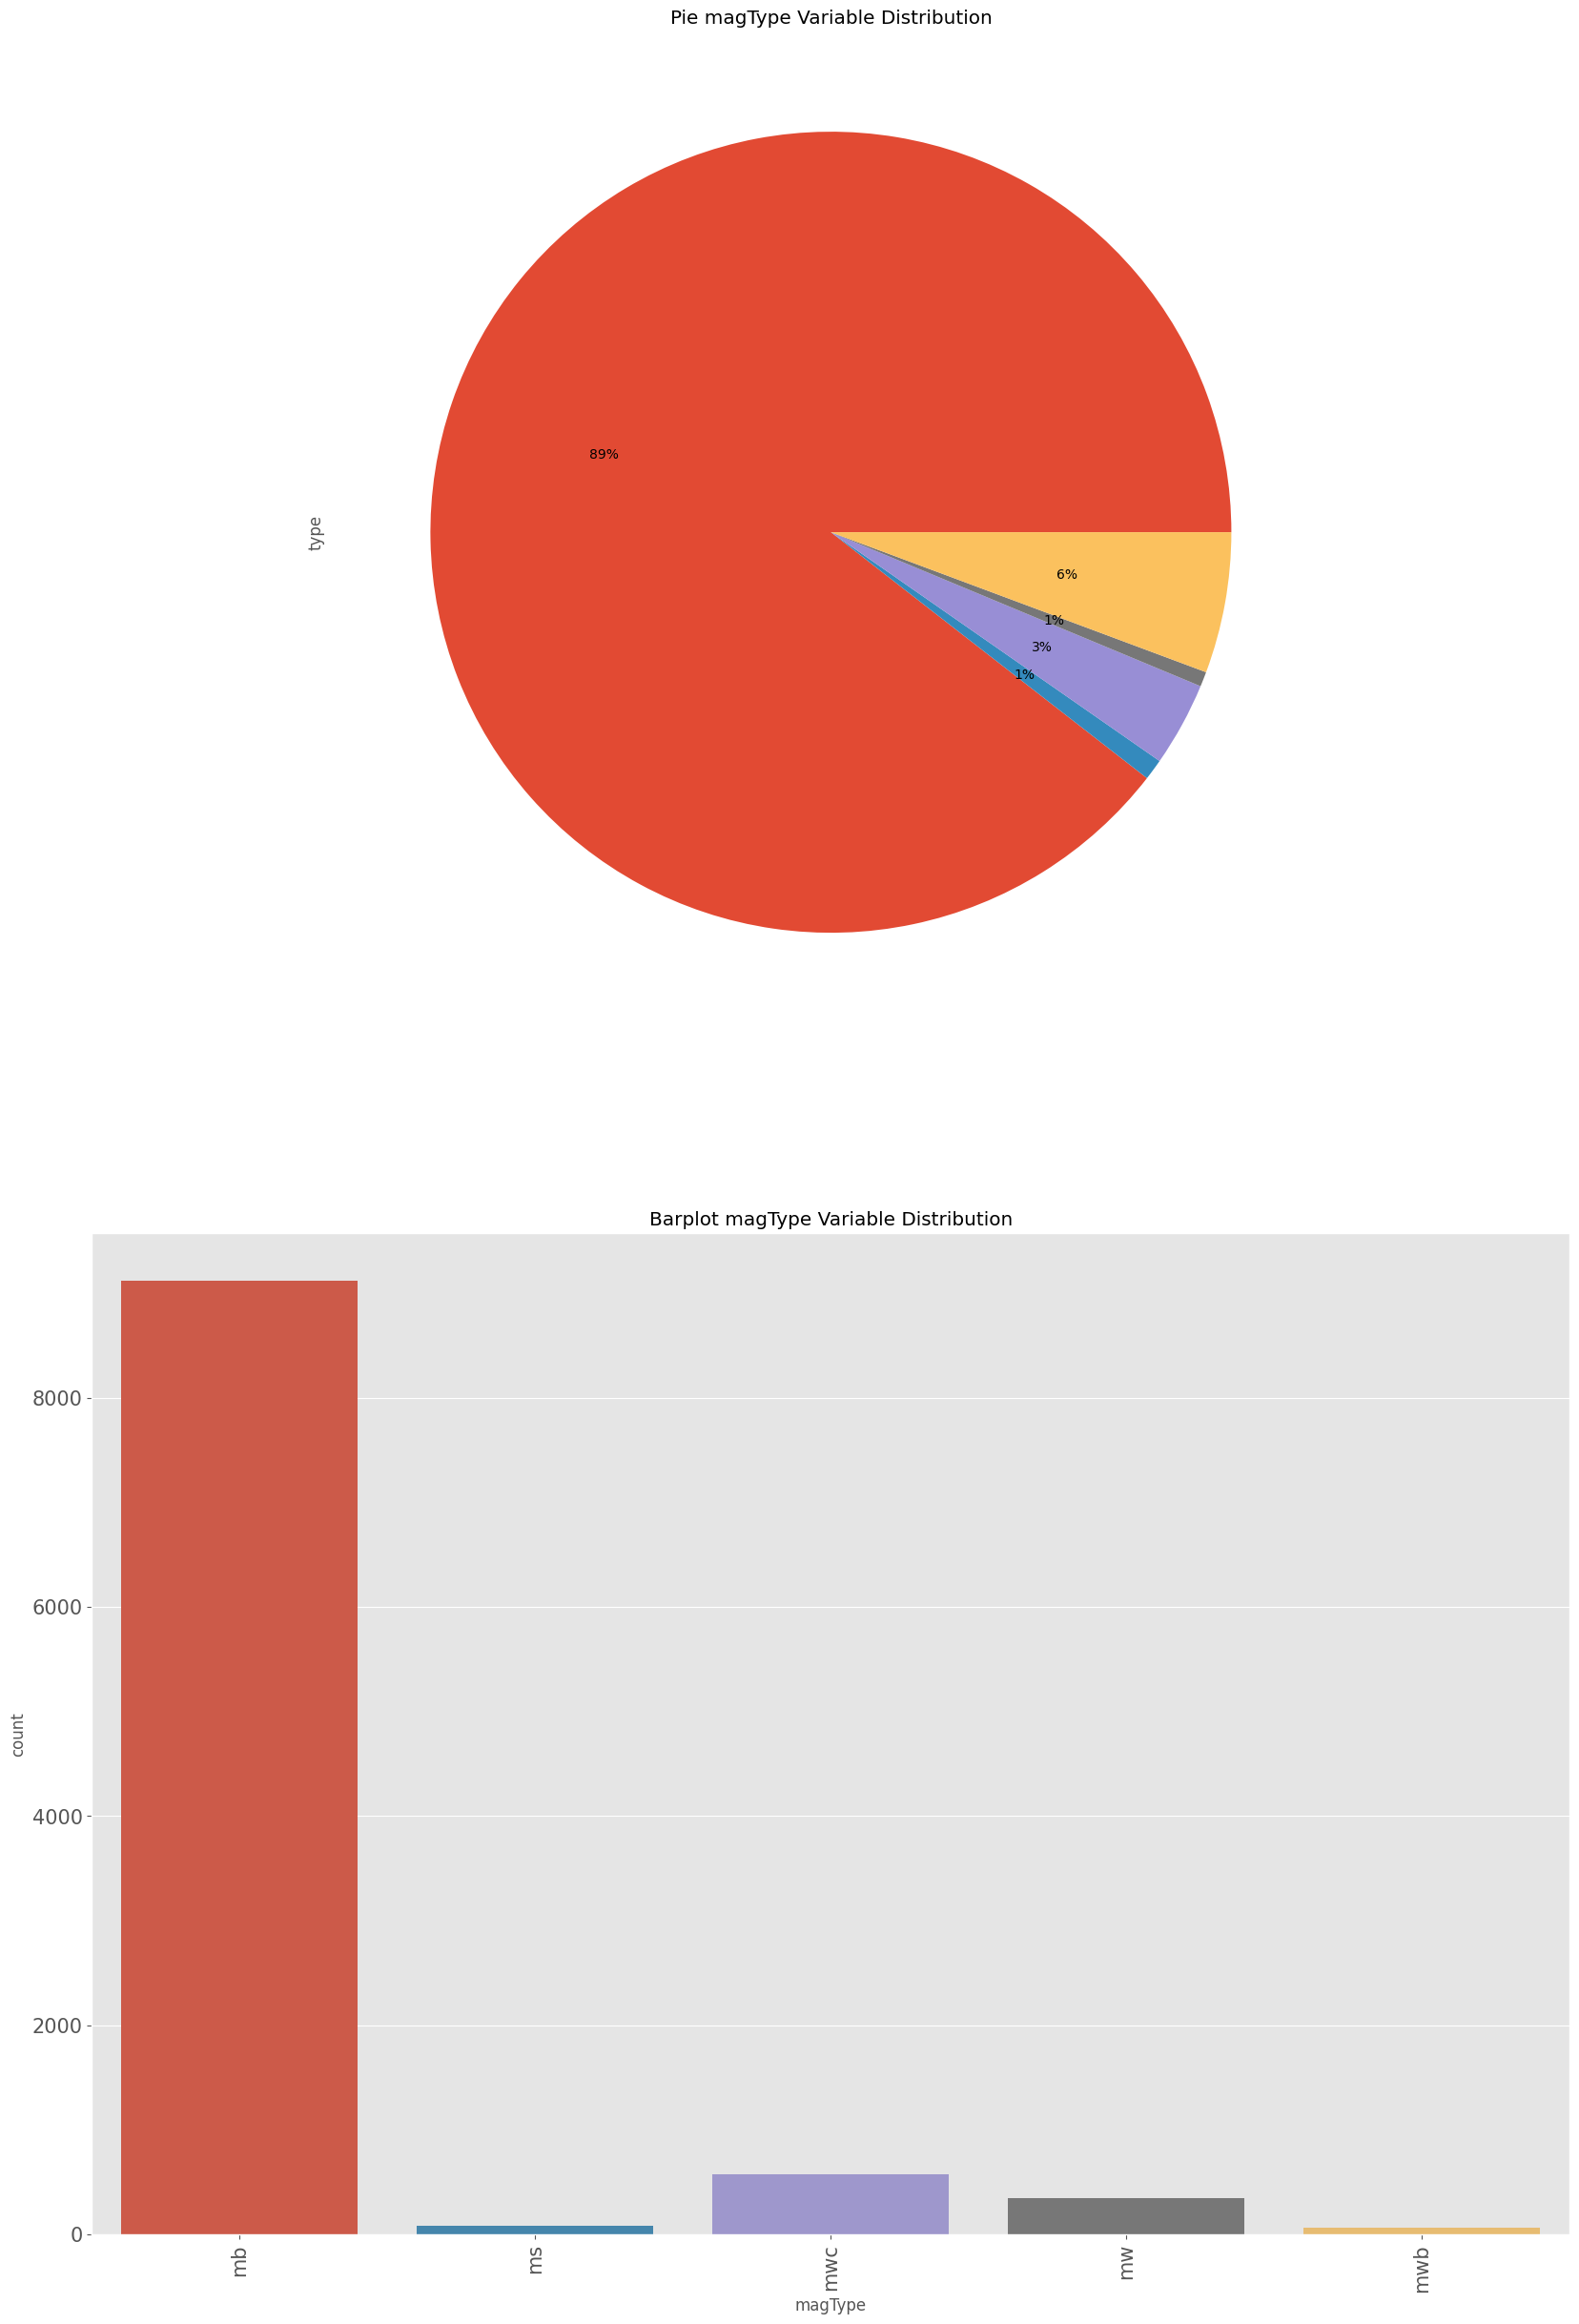

In [39]:
plot_cat(df, col1='magType', col2='type')

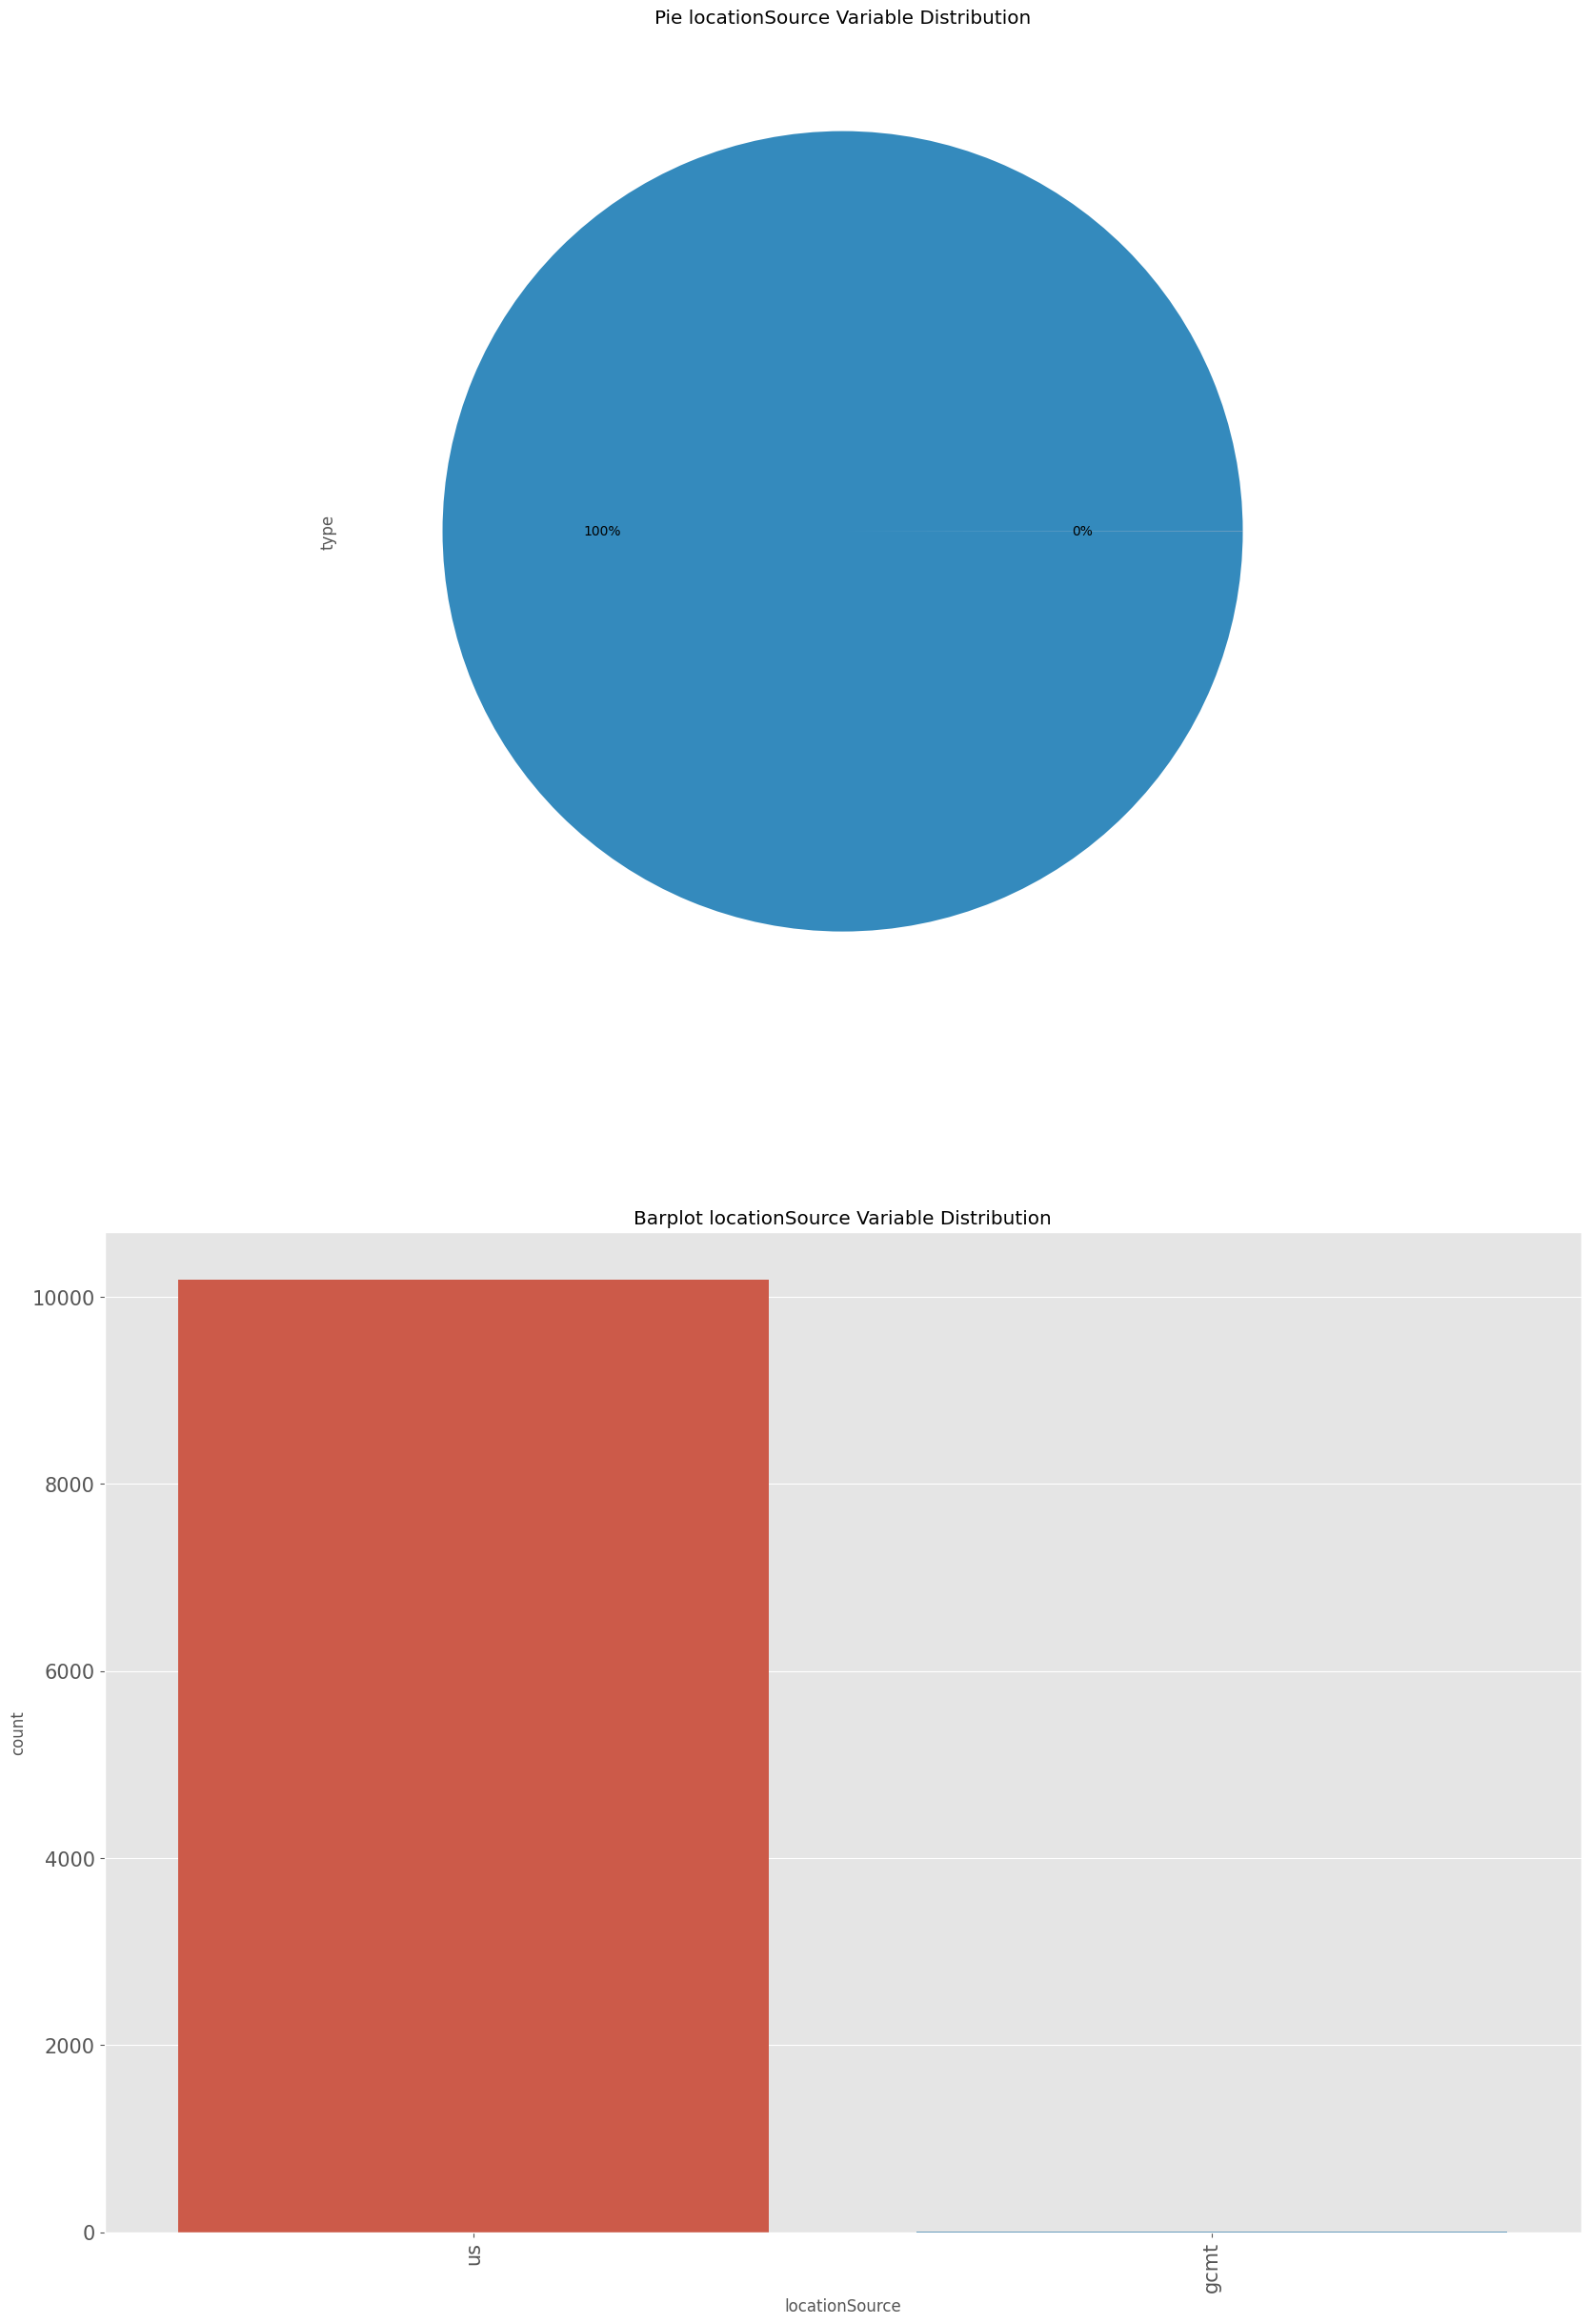

In [40]:
plot_cat(df, col1='locationSource', col2='type')

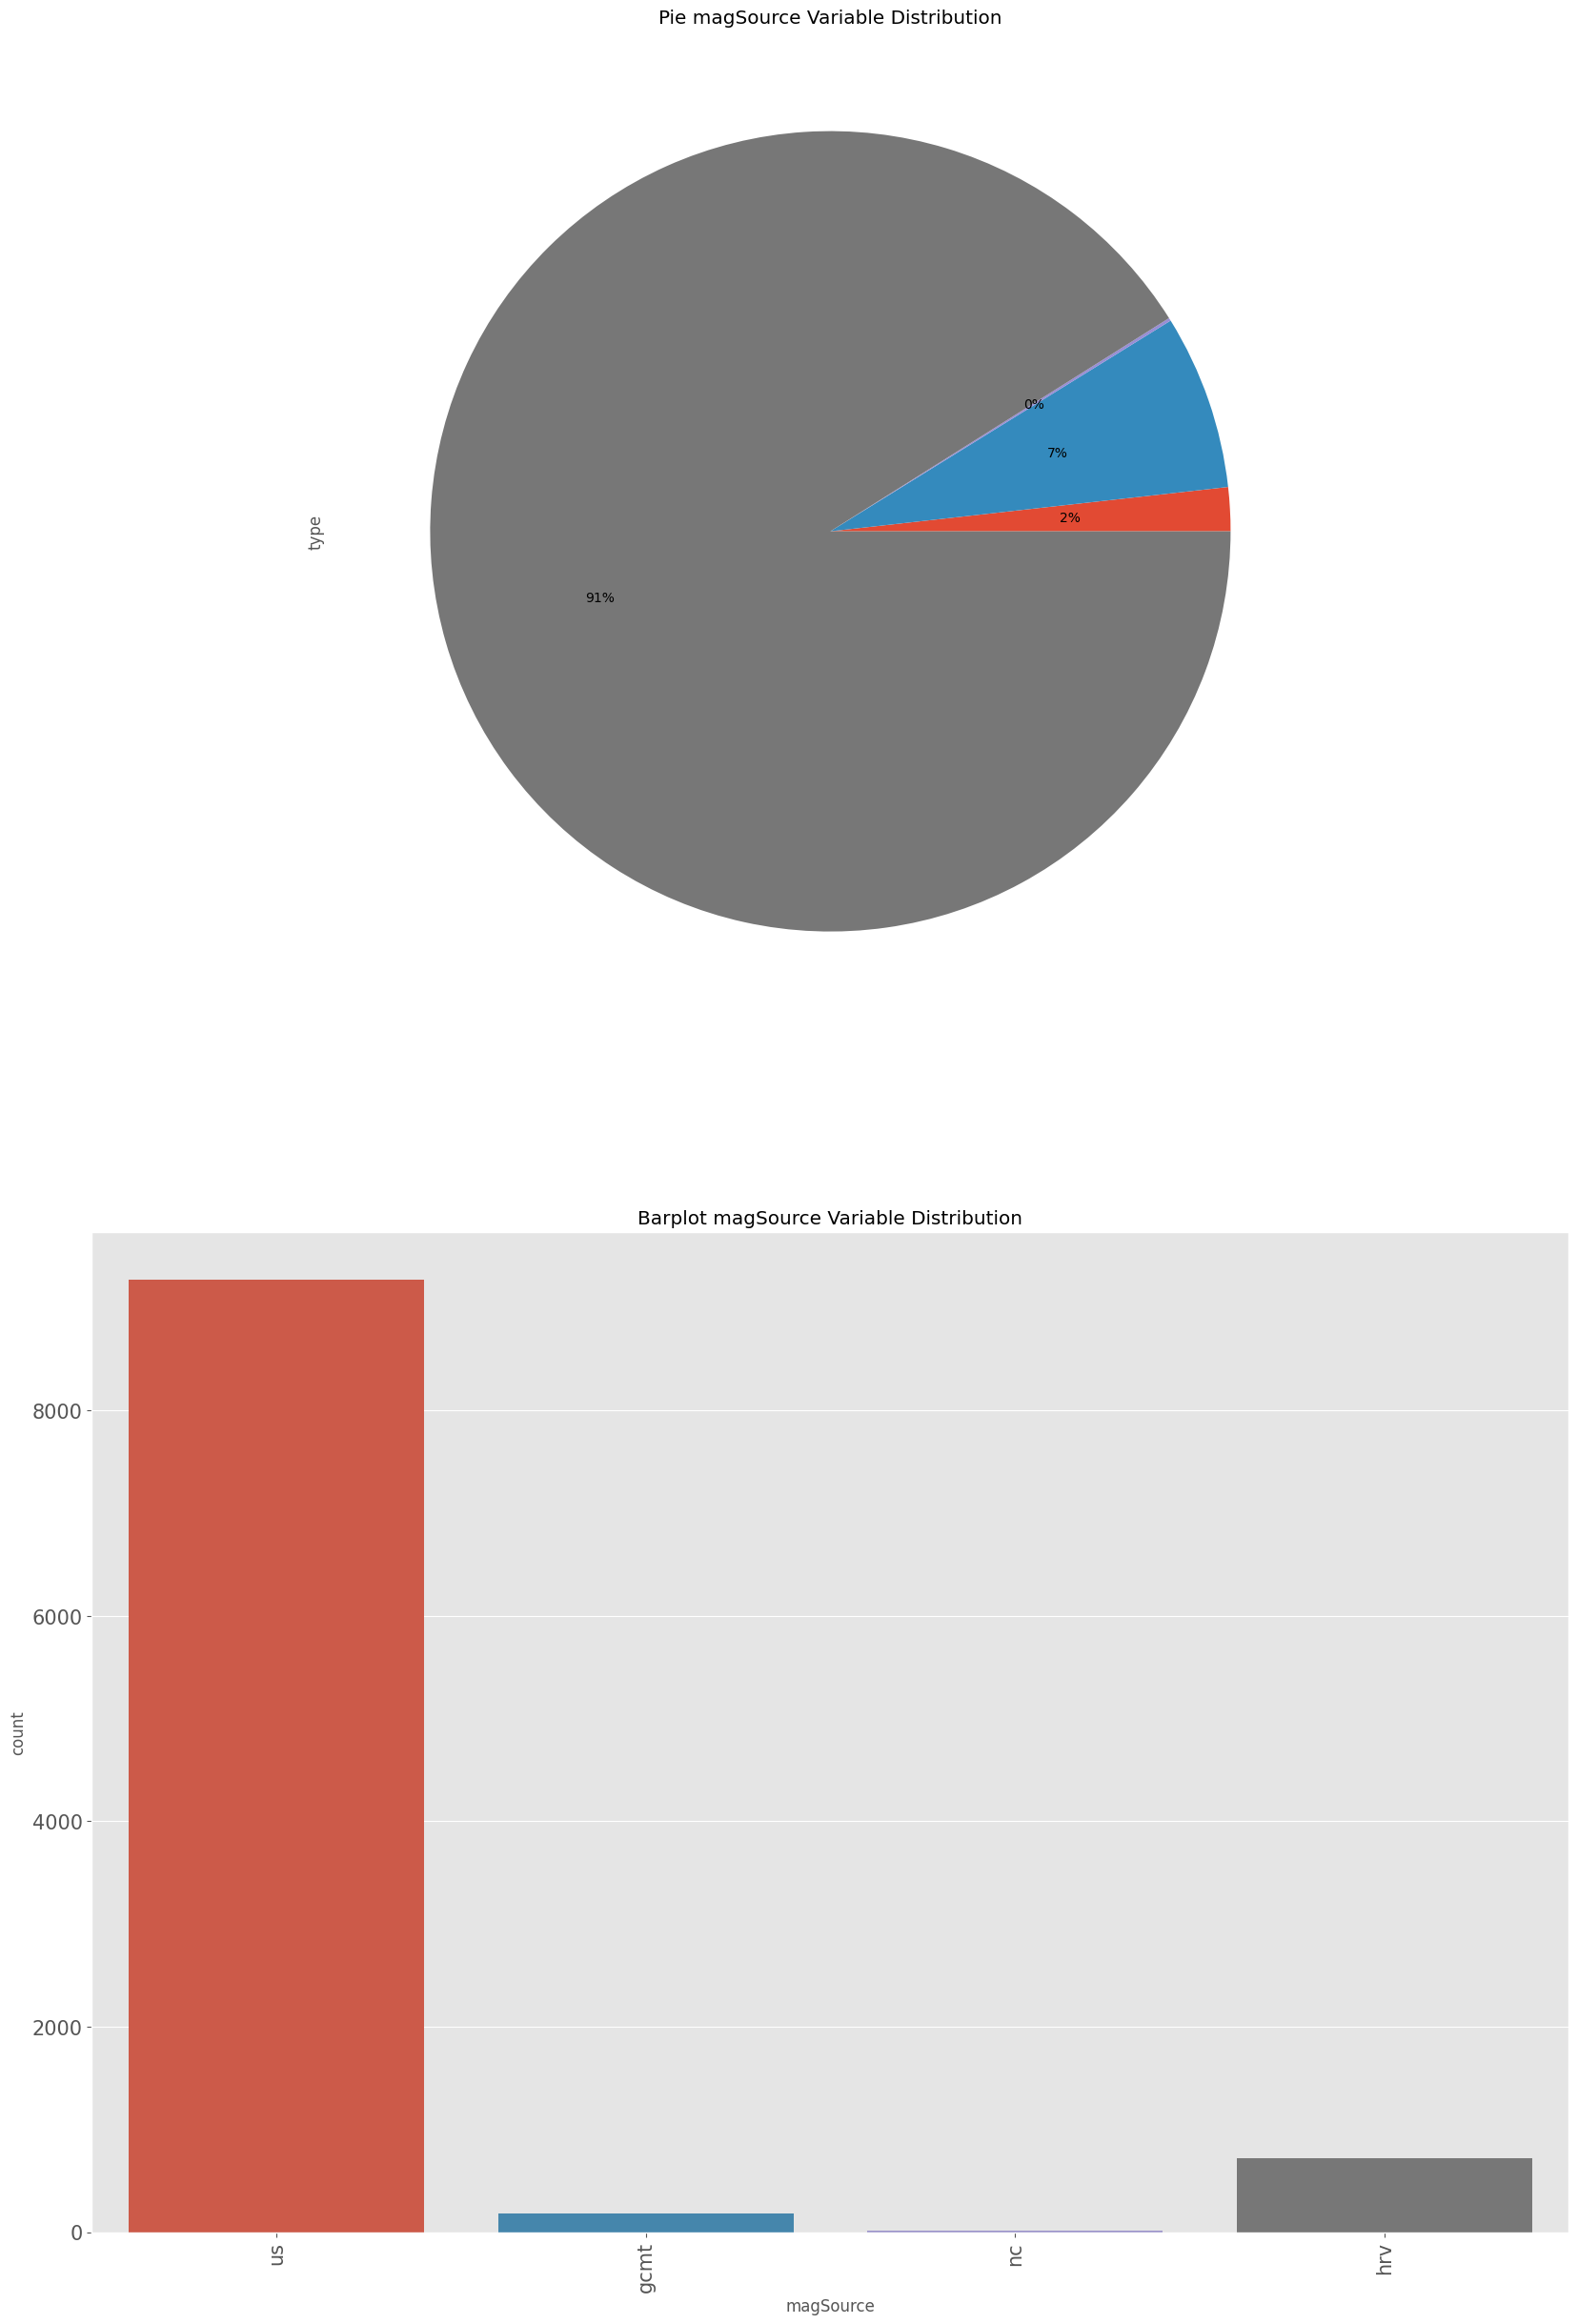

In [41]:
plot_cat(df, col1='magSource', col2='type')

In [42]:
# Univariate analysis looking at frequency
for col in cat:
    count = pd.crosstab(index = cat[col], columns="count")
    percentage = pd.crosstab(index = cat[col], columns="frequency")/pd.crosstab(index = cat[col], columns="frequency").sum()
    tab = pd.concat([count, percentage], axis=1)
    print('\n',tab)


 col_0    count  frequency
magType                  
mb        9116   0.894778
ms          86   0.008441
mw         346   0.033962
mwb         61   0.005987
mwc        579   0.056832

 col_0                                count  frequency
place                                                
Babuyan Islands region, Philippines     30   0.002945
Bohol, Philippines                      76   0.007460
Catanduanes, Philippines               157   0.015410
Celebes Sea                            146   0.014331
Kepulauan Sangihe, Indonesia            79   0.007754
Kepulauan Talaud, Indonesia            195   0.019140
Leyte, Philippines                     312   0.030624
Luzon, Philippines                    1471   0.144386
Masbate region, Philippines             79   0.007754
Mindanao, Philippines                 3951   0.387809
Mindoro, Philippines                   678   0.066549
Moro Gulf, Mindanao, Philippines       124   0.012171
Negros - Cebu region, Philippines       30   0.002945
Negr

### Numerical features analysis

In [43]:
# Select numerical columns
numerical_cols = [var for var in X_full.columns if X_full[var].dtype in ['float64','int64']]

In [44]:
# Subset with numerical features
num = X_full[numerical_cols]
num.columns

Index(['latitude', 'longitude', 'depth'], dtype='object')

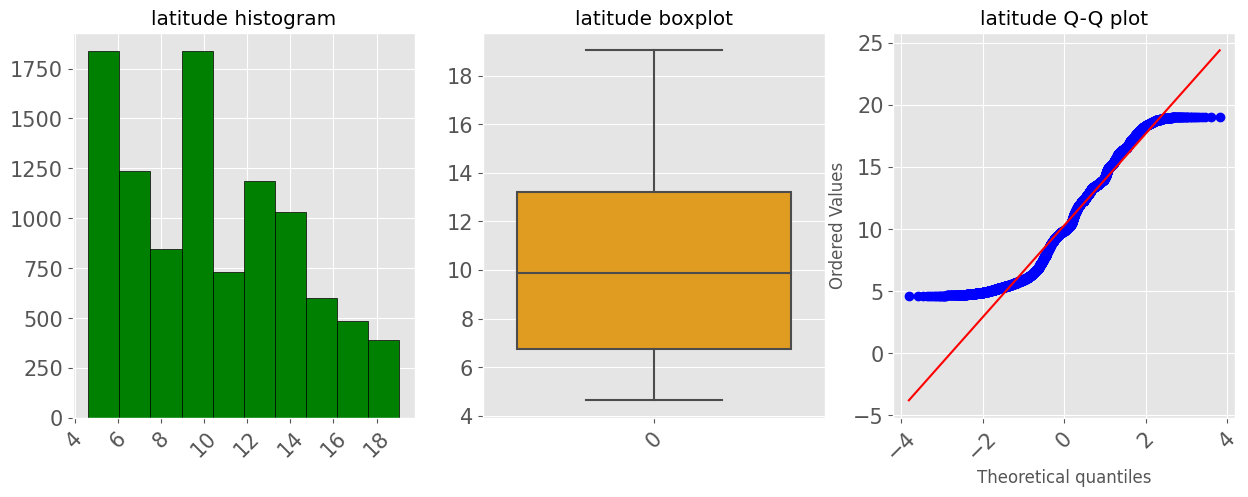

In [45]:
plot_num(num, var='latitude')

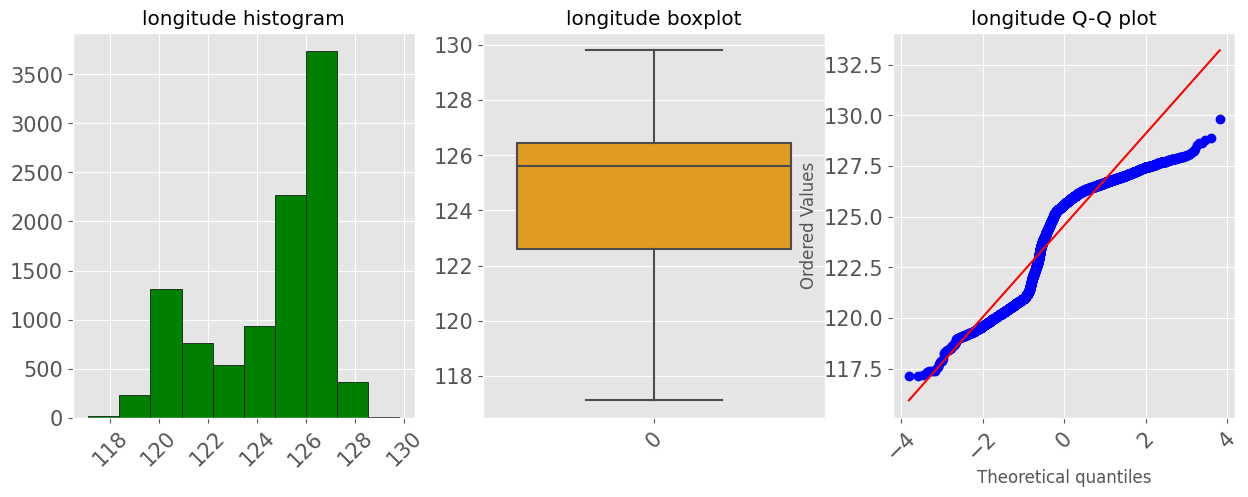

In [46]:
plot_num(num, var='longitude')

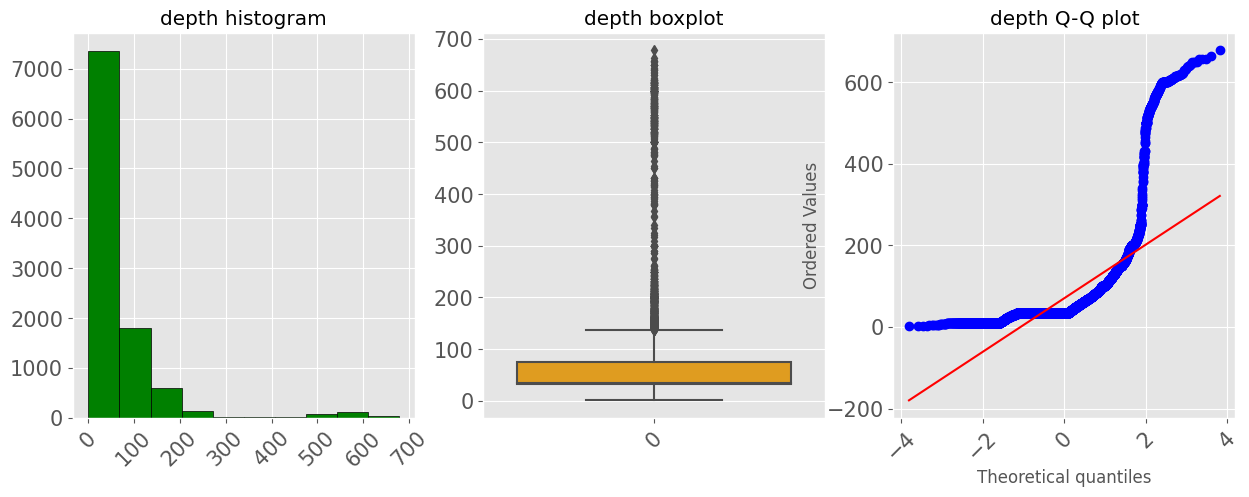

In [47]:
plot_num(num, var='depth')